<center><h1>San Francisco Crime Classification - Modelling</h1></center>

### `import` Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from tabulate import tabulate

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier

### Data Reading

In [2]:
project_path = '/content/drive/MyDrive/AAIC/SCS-1/sf_crime_classification/'

In [3]:
train_sf_df = pd.read_csv(filepath_or_buffer=project_path + 'csv_files/train_data_features.csv')
test_sf_df = pd.read_csv(filepath_or_buffer=project_path + 'csv_files/test_data_features.csv')
df = pd.read_csv(filepath_or_buffer=project_path + 'csv_files/train.csv')

In [4]:
train_sf_df['category'] = df['Category']
test_sf_df = test_sf_df.drop(columns=['id'])

In [5]:
train_sf_df.shape

(878049, 131)

In [6]:
test_sf_df.shape

(884262, 130)

### Stratification Split

* The data is highly imbalanced.

In [7]:
data = train_sf_df

In [8]:
X = data.drop(columns=['category'])
y = data['category']

### Data Preprocessing

In [9]:
def preprocess_data(X):
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X

In [10]:
X_norm = preprocess_data(X=X)

### Data Splitting

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, stratify=y, test_size=0.20)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train, test_size=0.20)

In [12]:
len(y_train.value_counts()), len(y_valid.value_counts()), len(y_test.value_counts())

(39, 39, 39)

In [13]:
print("Training data shape : ", X_train.shape)
print("Validation data shape : ", X_valid.shape)
print("Test data shape : ", X_test.shape)

Training data shape :  (561951, 130)
Validation data shape :  (140488, 130)
Test data shape :  (175610, 130)


### Labels for Confusion Matrix

In [14]:
labels = [
    'ARSON',
    'ASSAULT',
    'BAD CHECKS',
    'BRIBERY',
    'BURGLARY',
    'DISORDERLY CONDUCT',
    'DRIVING UNDER THE INFLUENCE',
    'DRUG/NARCOTIC',
    'DRUNKENNESS',
    'EMBEZZLEMENT',
    'EXTORTION',
    'FAMILY OFFENSES',
    'FORGERY/COUNTERFEITING',
    'FRAUD',
    'GAMBLING',
    'KIDNAPPING',
    'LARCENY/THEFT',
    'LIQUOR LAWS',
    'LOITERING',
    'MISSING PERSON',
    'NON-CRIMINAL',
    'OTHER OFFENSES',
    'PORNOGRAPHY/OBSCENE MAT',
    'PROSTITUTION',
    'RECOVERED VEHICLE',
    'ROBBERY',
    'RUNAWAY',
    'SECONDARY CODES',
    'SEX OFFENSES FORCIBLE',
    'SEX OFFENSES NON FORCIBLE',
    'STOLEN PROPERTY',
    'SUICIDE',
    'SUSPICIOUS OCC',
    'TREA',
    'TRESPASS',
    'VANDALISM',
    'VEHICLE THEFT',
    'WARRANTS',
    'WEAPON LAWS'
 ]

### Confusion, Precision, and Recall Matrices

In [15]:
def plot_heatmap(matrix, title, labels, cmap='YlGnBu'):
    plt.figure(figsize=(25, 20))
    sns.heatmap(matrix, annot=True, cmap=cmap, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return None

def plot_confusion_matrix(y_actuals, y_preds, labels=labels):
    # confusion matrix
    cmat = confusion_matrix(y_true=y_actuals, y_pred=y_preds)
    # precision matrix
    pmat = cmat / cmat.sum(axis=0)
    # recall matrix
    rmat = cmat / cmat.sum(axis=1)
    # class labels
    
    plot_heatmap(matrix=cmat, title='Confusion Matrix', labels=labels)
    plot_heatmap(matrix=pmat, title='Precision Matrix', labels=labels)
    plot_heatmap(matrix=rmat, title='Recall Matrix', labels=labels)
    
    return None

### 1. Dummy Classifier

In [16]:
def dummy_classifier(X_train, y_train, X_valid, y_valid, X_test, y_test, show_plot=True):
    model_path = project_path + 'models/'
    model_name = 'dummy_classifier.pkl'

    if not os.path.isfile(path=model_path + model_name):
        clf = DummyClassifier(strategy='uniform')
        clf.fit(X=X_train, y=y_train)

        sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
        sig_clf.fit(X_train, y_train)
        
        pickle.dump(sig_clf, open(model_path + model_name, 'wb'))
    else:
        print('Model already exists.')
        sig_clf = pickle.load(open(model_path + model_name, 'rb'))

    y_train_preds = sig_clf.predict_proba(X_train)
    train_log_loss = log_loss(y_train, y_train_preds)
    print("Training Log Loss:", train_log_loss)

    y_valid_preds = sig_clf.predict_proba(X_valid)
    valid_log_loss = log_loss(y_valid, y_valid_preds)
    print("Validation Log Loss:", valid_log_loss)

    y_test_preds = sig_clf.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_test_preds)
    print("Testing Log Loss:", test_log_loss)

    if show_plot:
        predict_y = sig_clf.predict(X_test)
        plot_confusion_matrix(y_actuals=y_test, y_preds=predict_y)
    
    classification_report = metrics.classification_report(y_test, predict_y)
    print(classification_report)
    
    return train_log_loss, valid_log_loss, test_log_loss

Model already exists.
Training Log Loss: 2.6803311916005748
Validation Log Loss: 2.6803405273212917
Testing Log Loss: 2.680302884126909


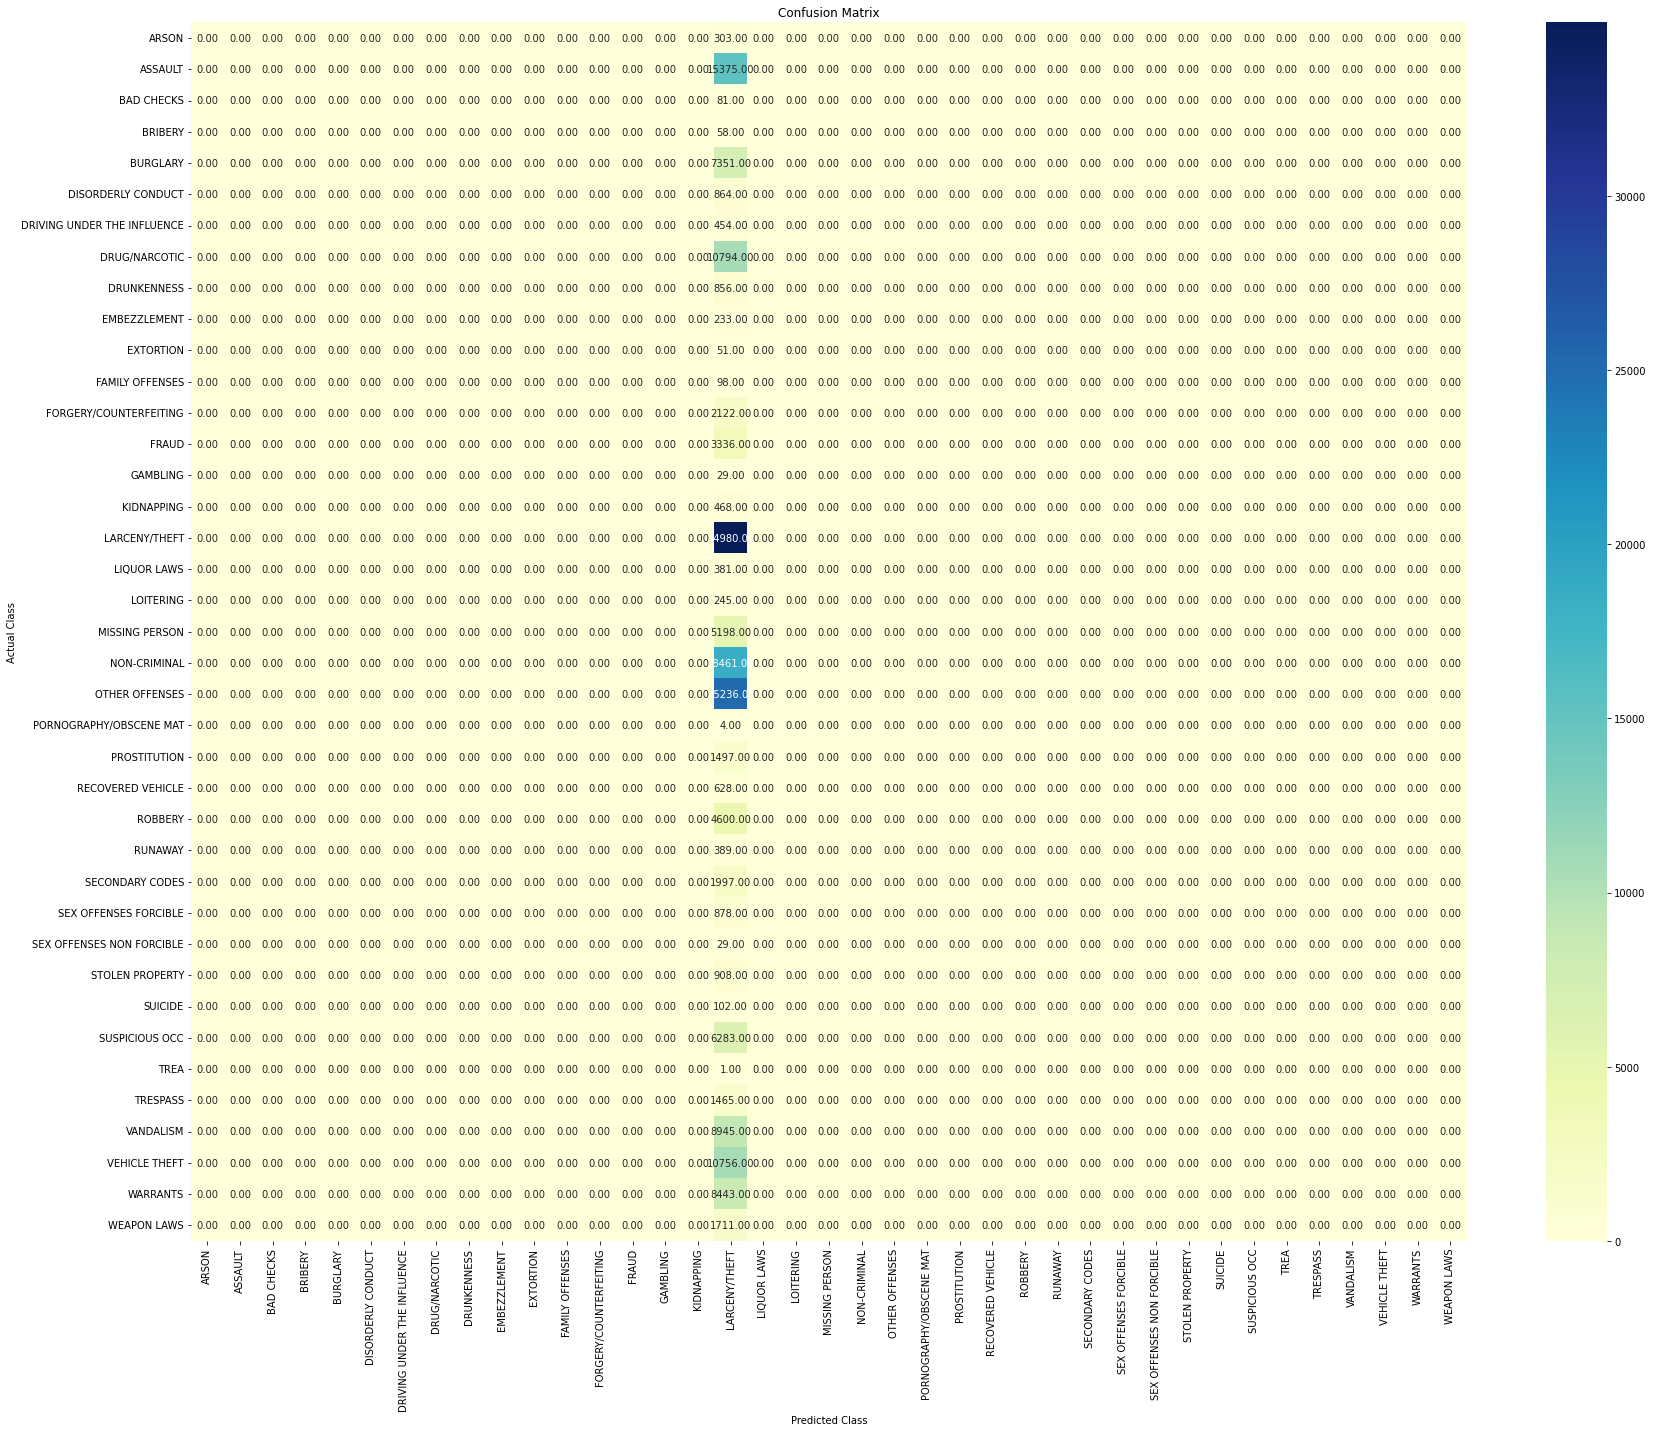

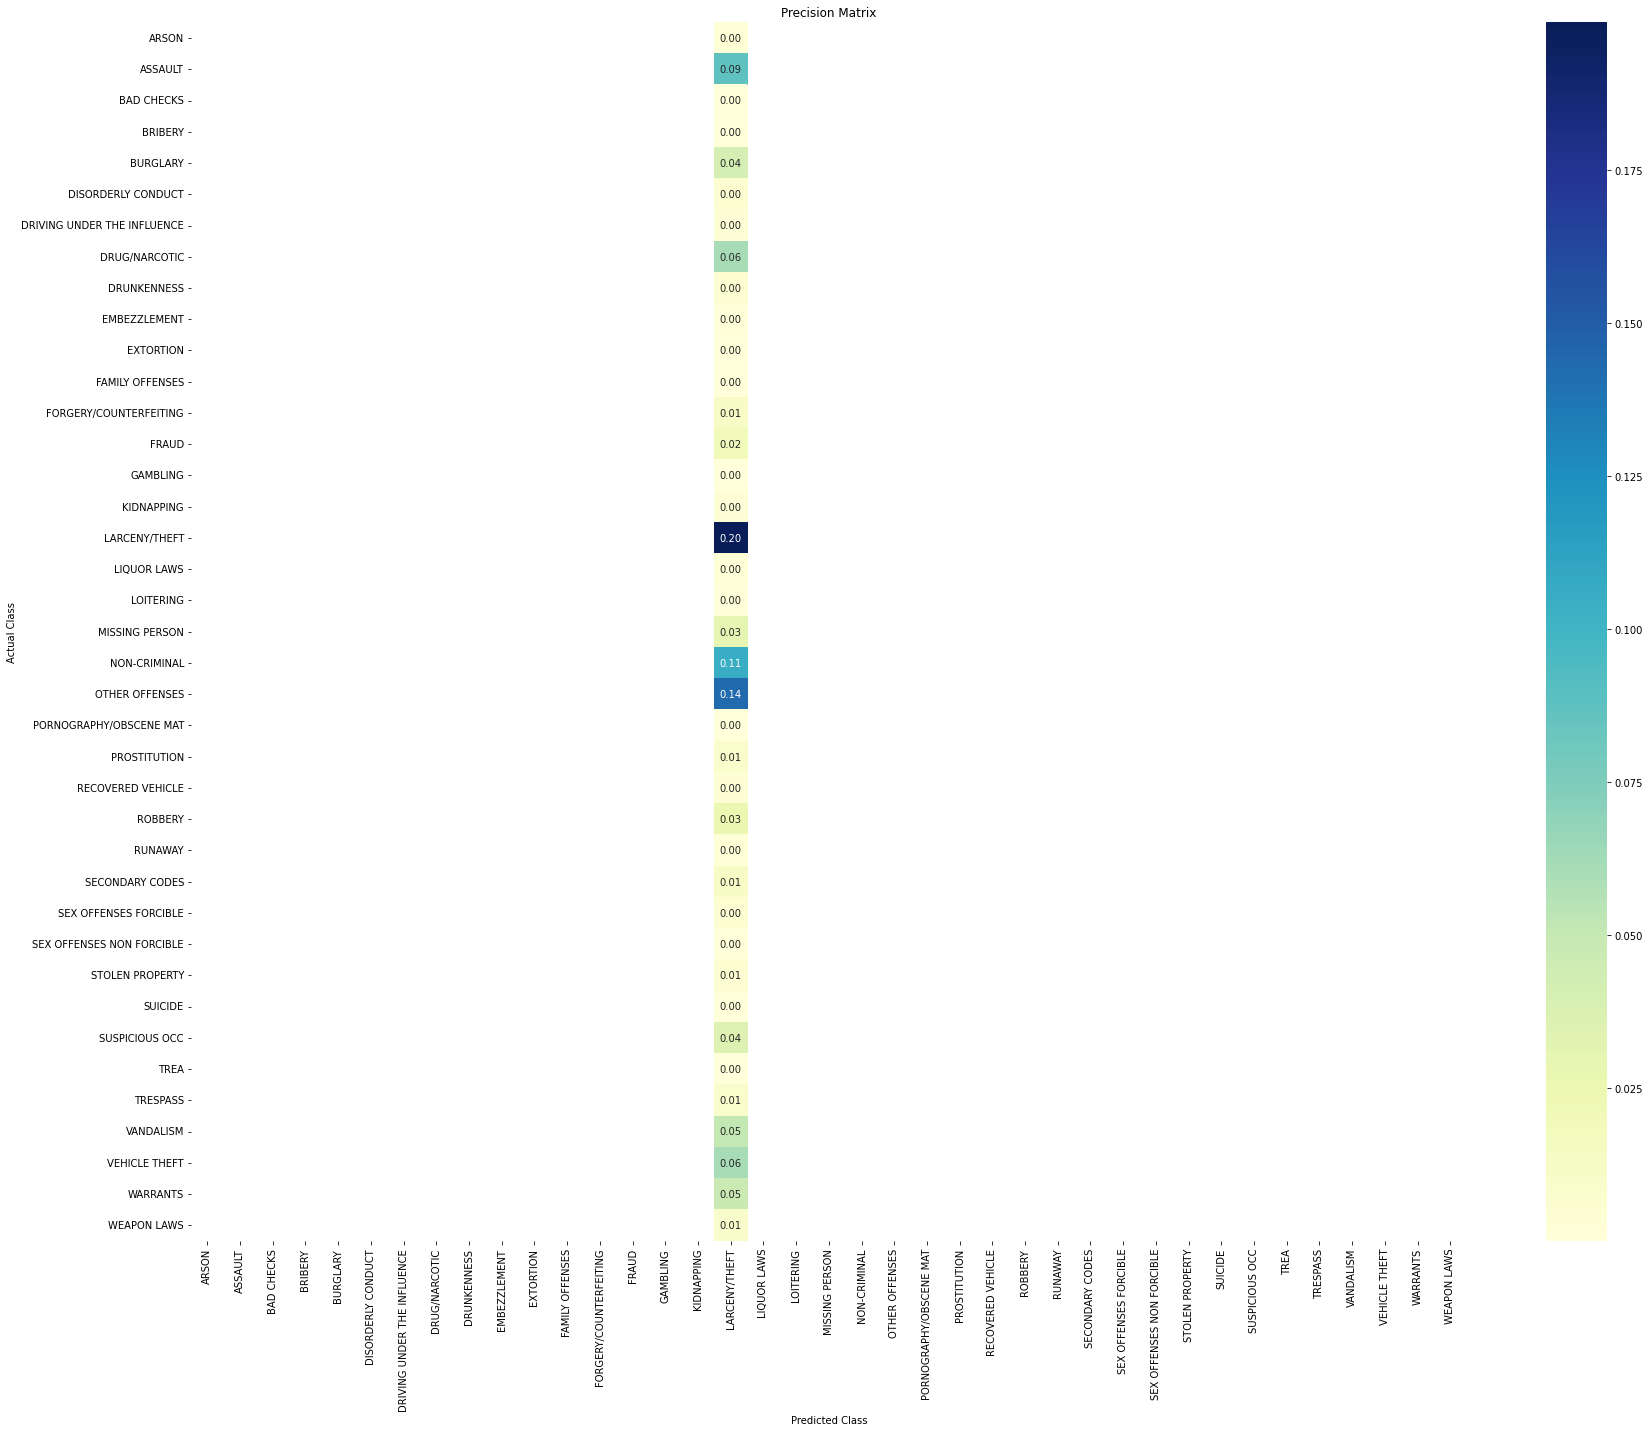

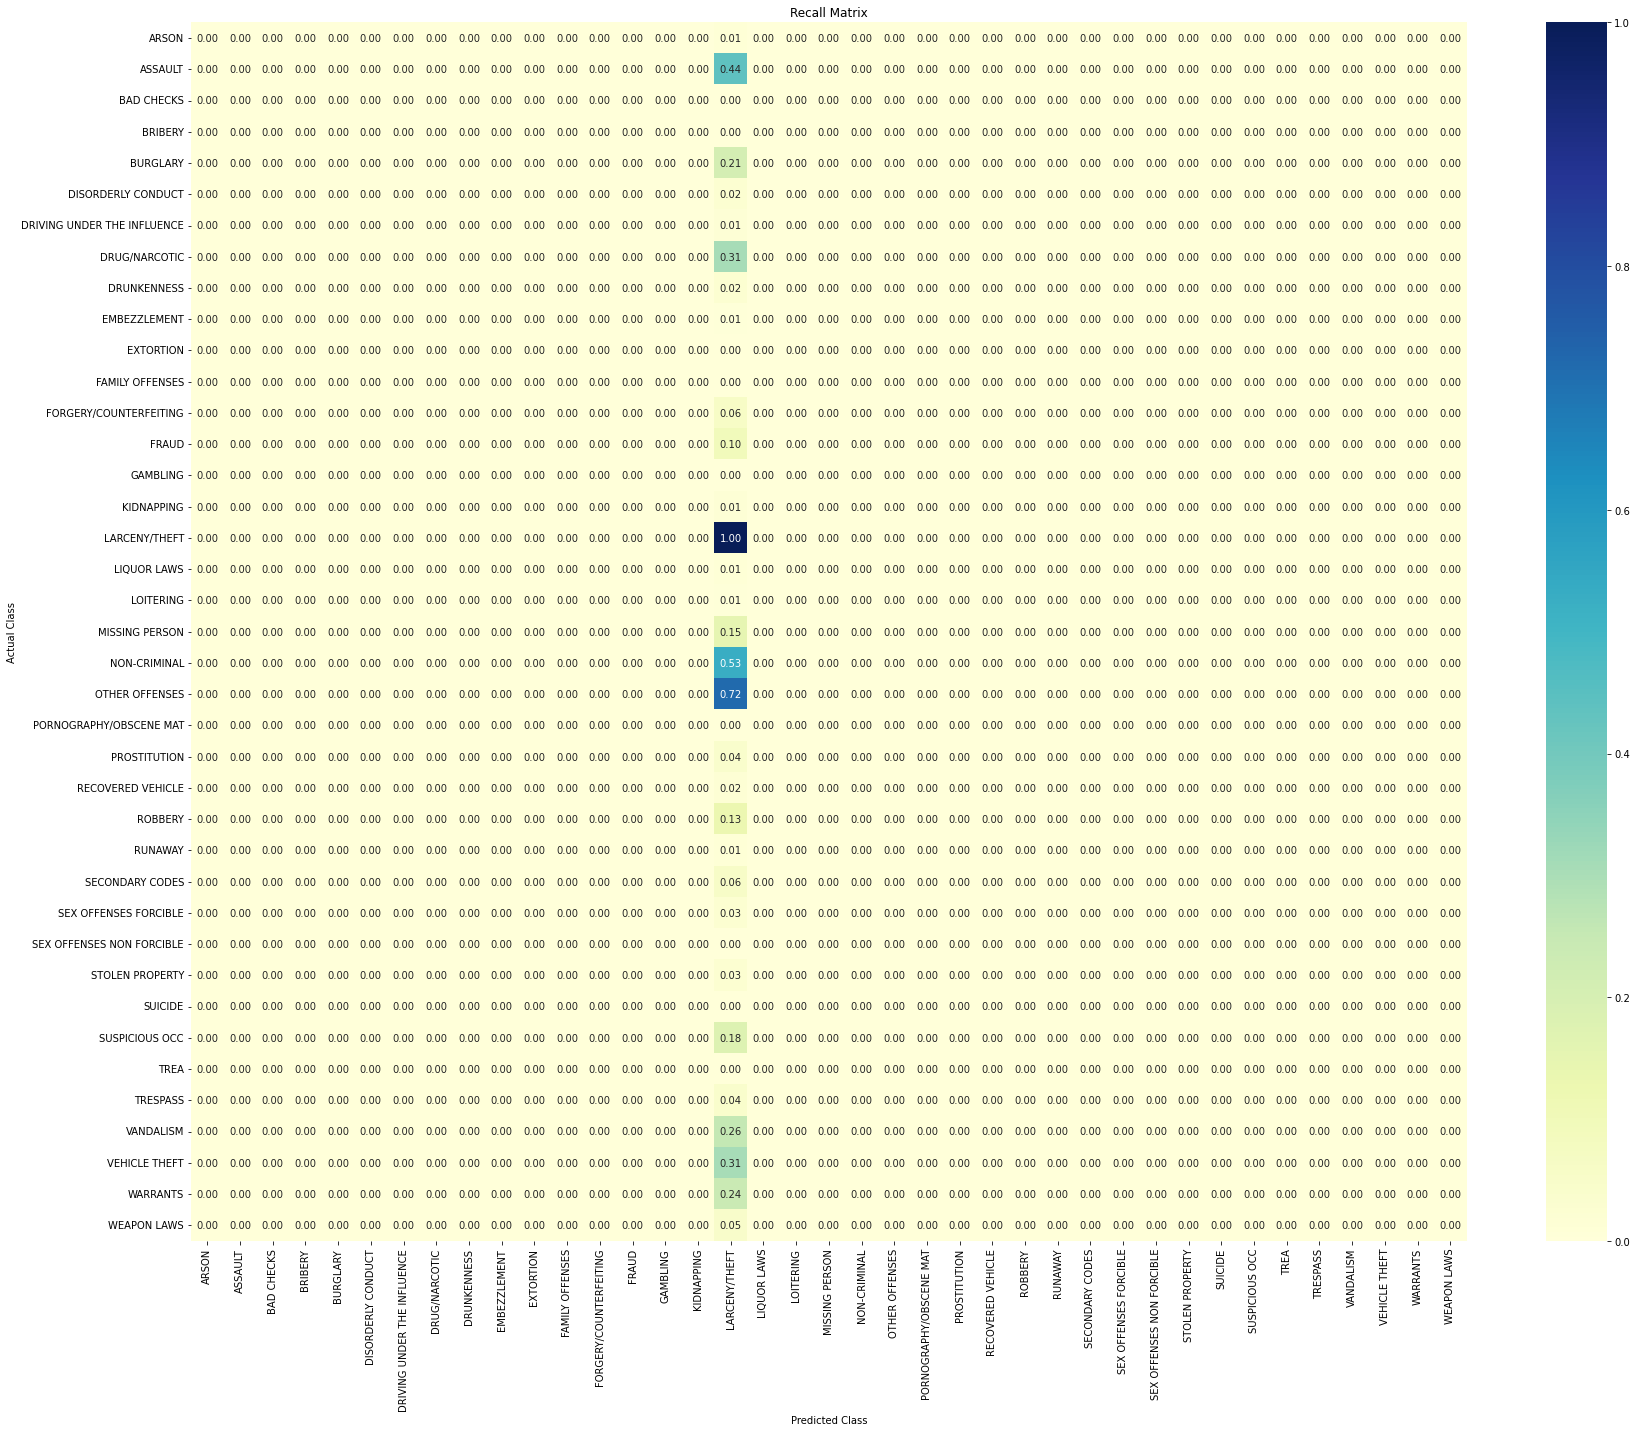

                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       303
                    ASSAULT       0.00      0.00      0.00     15375
                 BAD CHECKS       0.00      0.00      0.00        81
                    BRIBERY       0.00      0.00      0.00        58
                   BURGLARY       0.00      0.00      0.00      7351
         DISORDERLY CONDUCT       0.00      0.00      0.00       864
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       454
              DRUG/NARCOTIC       0.00      0.00      0.00     10794
                DRUNKENNESS       0.00      0.00      0.00       856
               EMBEZZLEMENT       0.00      0.00      0.00       233
                  EXTORTION       0.00      0.00      0.00        51
            FAMILY OFFENSES       0.00      0.00      0.00        98
     FORGERY/COUNTERFEITING       0.00      0.00      0.00      2122
                      FRAUD      

In [17]:
dummy_train_loss, dummy_valid_loss, dummy_test_loss = dummy_classifier(X_train, y_train, X_valid, y_valid, X_test, y_test)

### 2. Logistic Regression

In [18]:
def log_reg_classifier(X_train, y_train, X_valid, y_valid, X_test, y_test, show_plot=True):
    model_path = project_path + 'models/'
    model_name = 'log_reg_classifier.pkl'

    if not os.path.isfile(path=model_path + model_name):
        clf = LogisticRegression(penalty='l2', C=30, n_jobs=-1)
        clf.fit(X_train, y_train)

        sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
        sig_clf.fit(X_train, y_train)
    
        pickle.dump(sig_clf, open(model_path + model_name, 'wb'))
    else:
        print('Model already exists.')
        sig_clf = pickle.load(open(model_path + model_name, 'rb'))

    y_train_preds = sig_clf.predict_proba(X_train)
    train_log_loss = log_loss(y_train, y_train_preds)
    print("Training Log Loss:", train_log_loss)

    y_valid_preds = sig_clf.predict_proba(X_valid)
    valid_log_loss = log_loss(y_valid, y_valid_preds)
    print("Validation Log Loss:", valid_log_loss)

    y_test_preds = sig_clf.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_test_preds)
    print("Testing Log Loss:", test_log_loss)

    if show_plot:
        predict_y = sig_clf.predict(X_test)
        plot_confusion_matrix(y_actuals=y_test, y_preds=predict_y)
    
    classification_report = metrics.classification_report(y_test, predict_y)
    print(classification_report)

    return train_log_loss, valid_log_loss, test_log_loss

Model already exists.
Training Log Loss: 2.500360732705917
Validation Log Loss: 2.496850823942772
Testing Log Loss: 2.4981216691332824


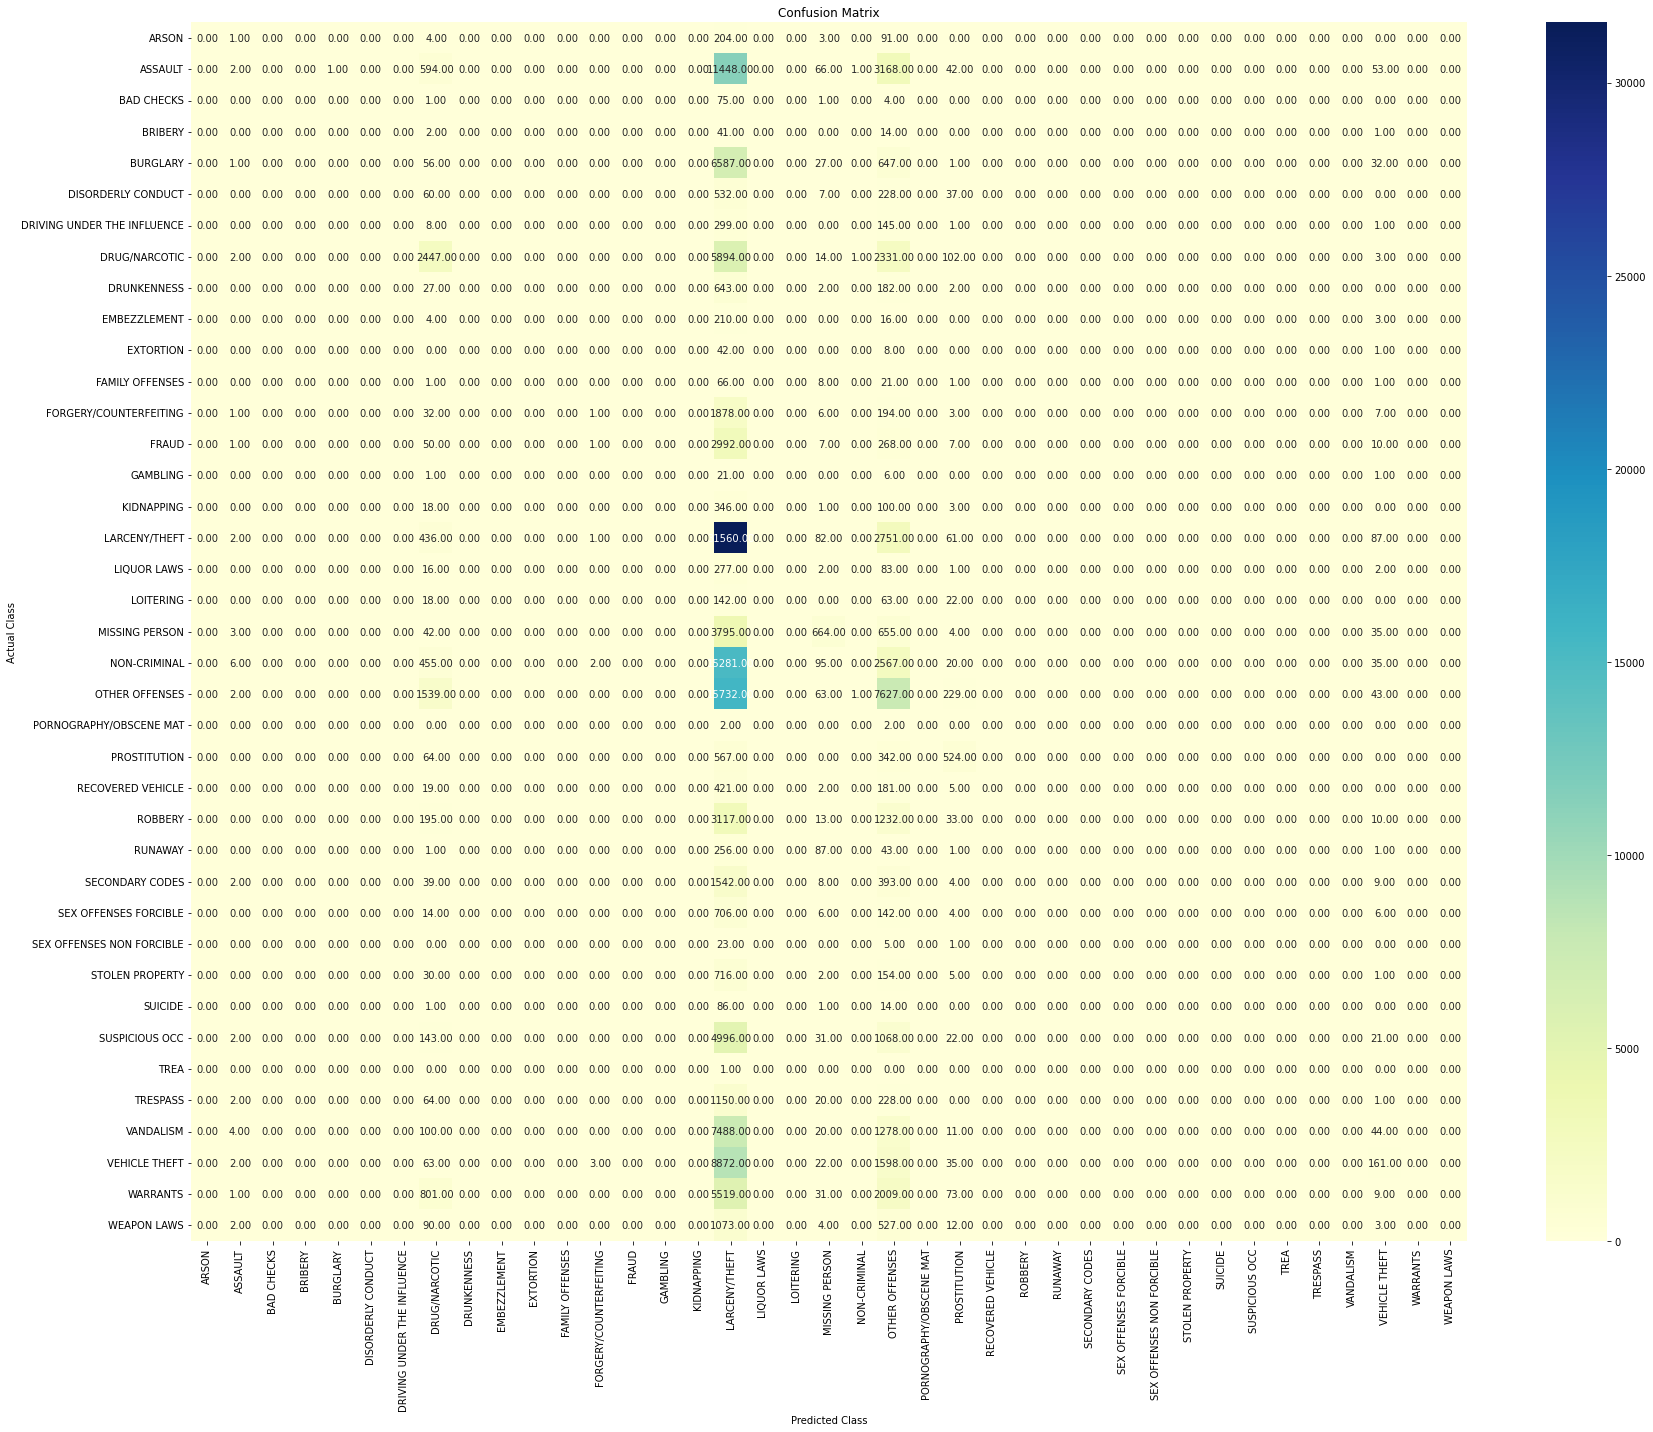

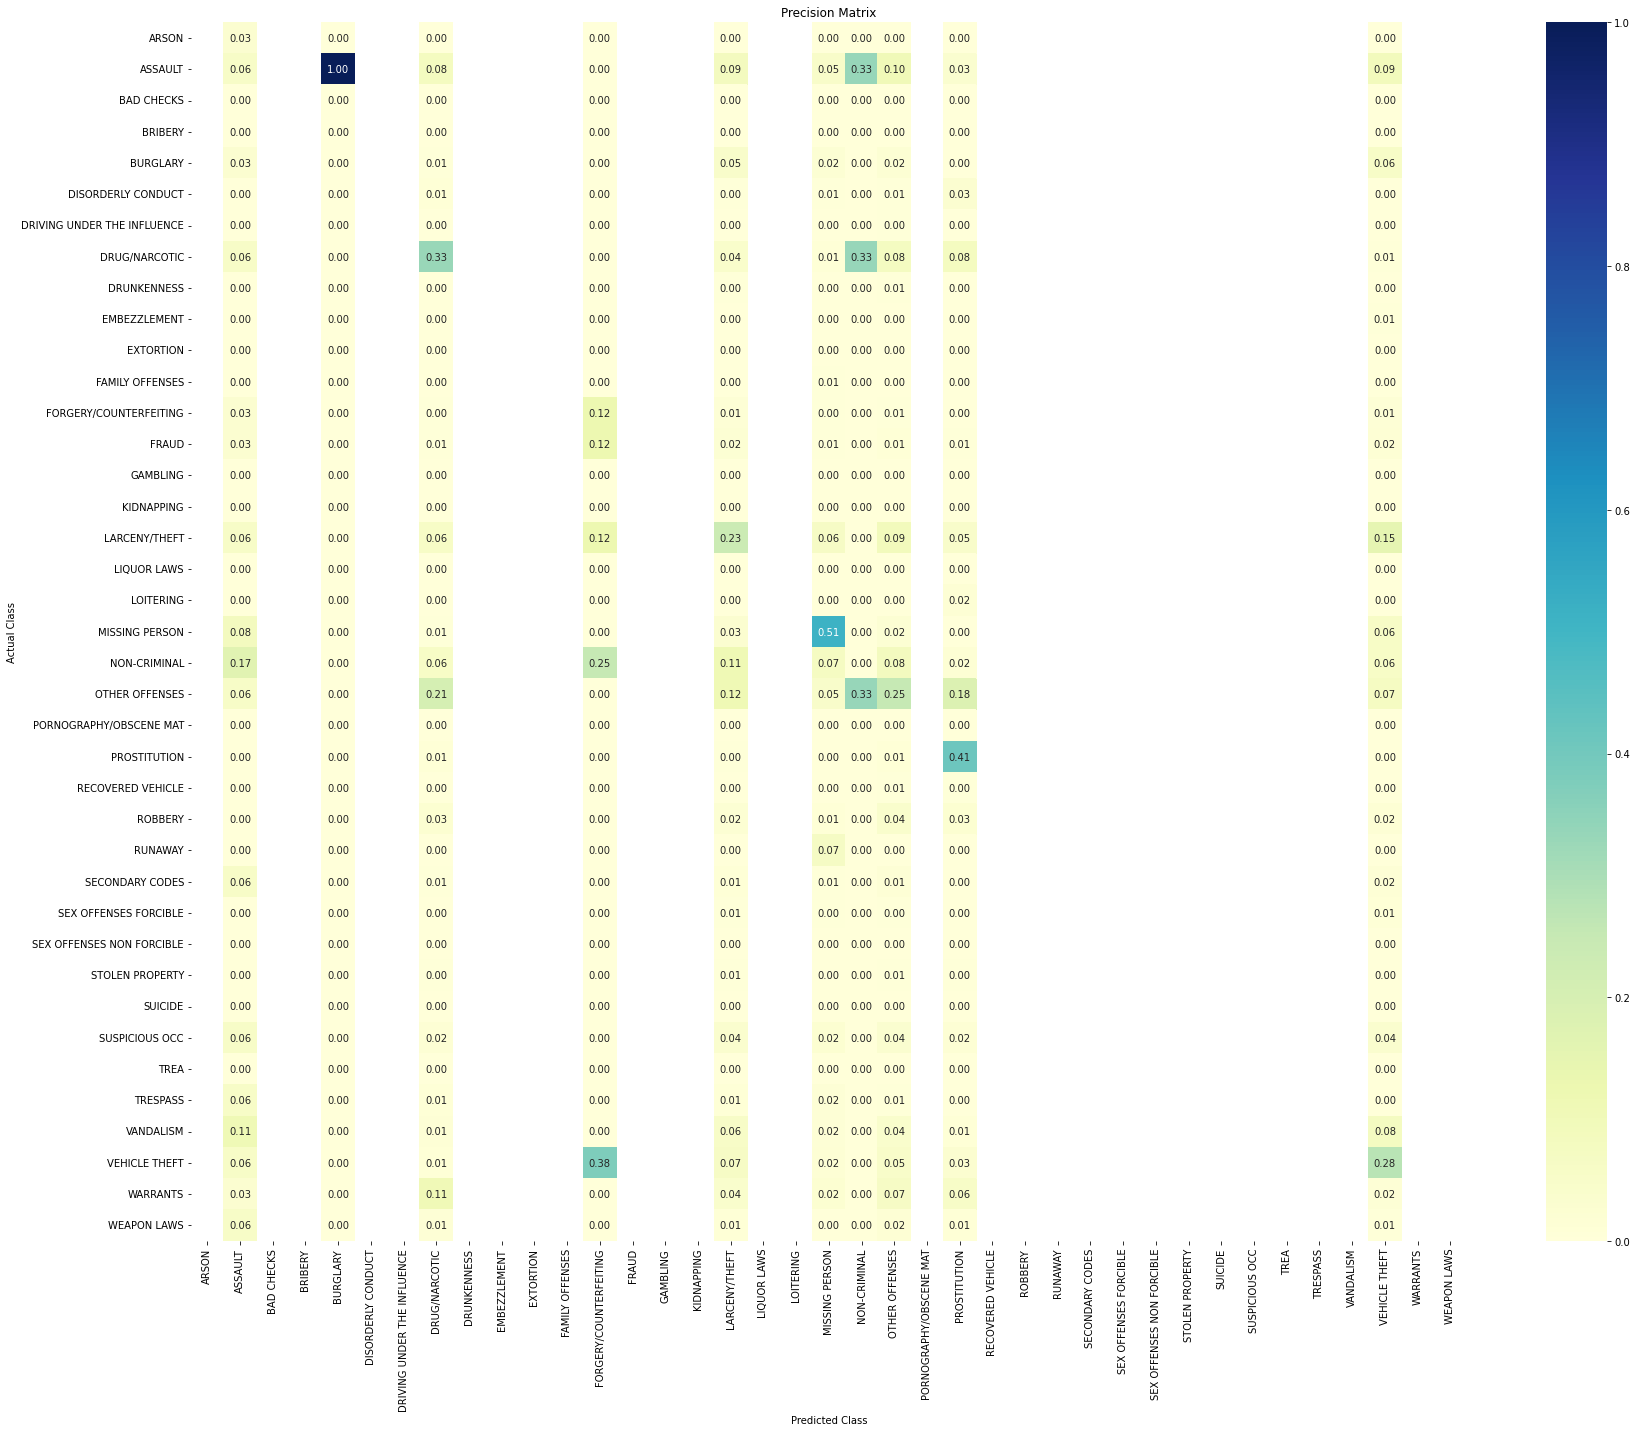

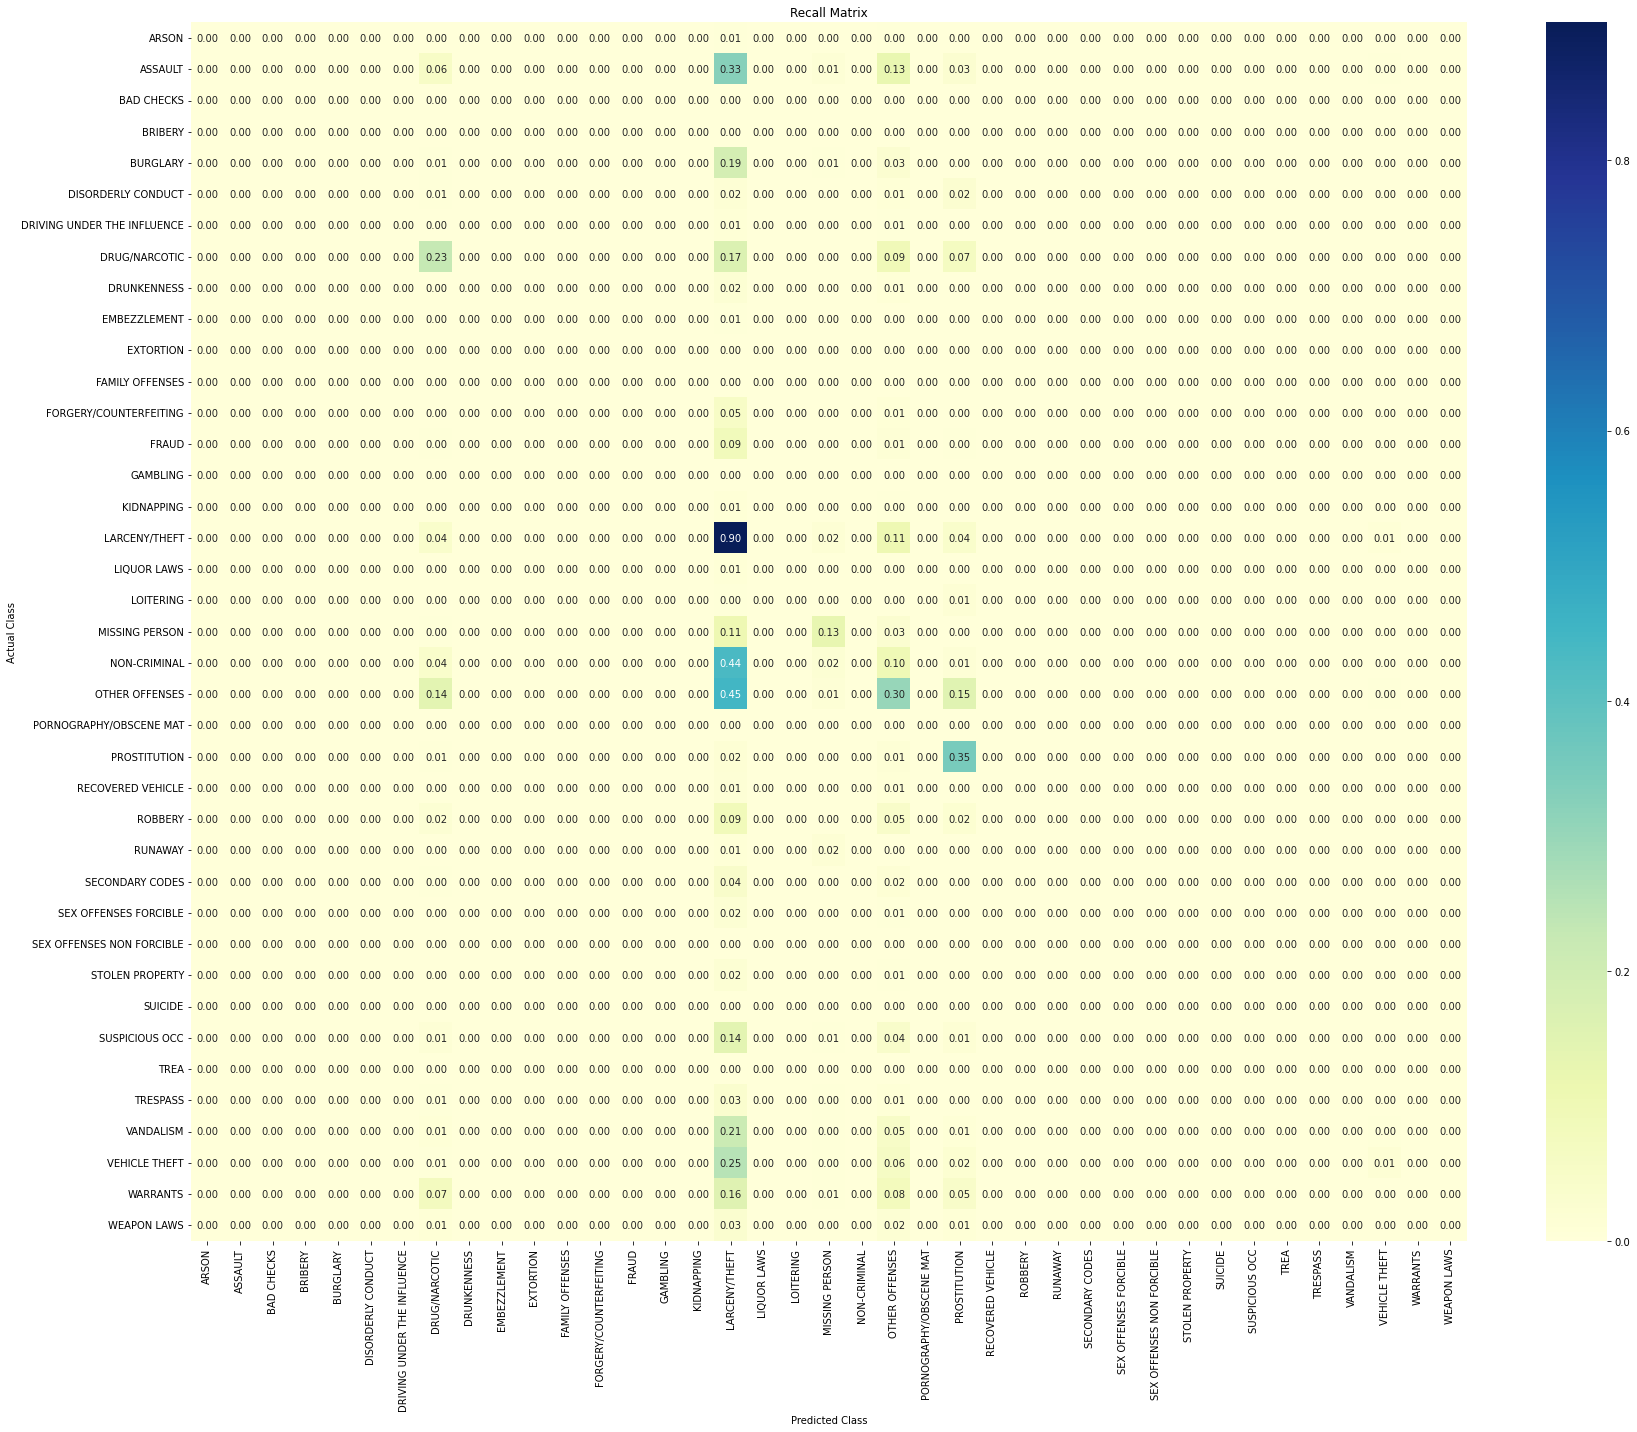

                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       303
                    ASSAULT       0.06      0.00      0.00     15375
                 BAD CHECKS       0.00      0.00      0.00        81
                    BRIBERY       0.00      0.00      0.00        58
                   BURGLARY       0.00      0.00      0.00      7351
         DISORDERLY CONDUCT       0.00      0.00      0.00       864
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       454
              DRUG/NARCOTIC       0.33      0.23      0.27     10794
                DRUNKENNESS       0.00      0.00      0.00       856
               EMBEZZLEMENT       0.00      0.00      0.00       233
                  EXTORTION       0.00      0.00      0.00        51
            FAMILY OFFENSES       0.00      0.00      0.00        98
     FORGERY/COUNTERFEITING       0.12      0.00      0.00      2122
                      FRAUD      

In [19]:
lr_train_loss, lr_valid_loss, lr_test_loss = log_reg_classifier(X_train, y_train, X_valid, y_valid, X_test, y_test)

### 3. Decision Tree Classifier

In [20]:
def decision_tree_classifier(X_train, y_train, X_valid, y_valid, X_test, y_test, show_plot=True):
    model_path = project_path + 'models/'
    model_name = 'decision_tree_classifier.pkl'

    if not os.path.isfile(path=model_path + model_name):
        clf = DecisionTreeClassifier(max_depth=50, min_samples_split=500)
        clf.fit(X_train, y_train)

        sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
        sig_clf.fit(X_train, y_train)
    
        pickle.dump(sig_clf, open(model_path + model_name, 'wb'))
    else:
        print('Model already exists.')
        sig_clf = pickle.load(open(model_path + model_name, 'rb'))

    y_train_preds = sig_clf.predict_proba(X_train)
    train_log_loss = log_loss(y_train, y_train_preds)
    print("Training Log Loss:", train_log_loss)

    y_valid_preds = sig_clf.predict_proba(X_valid)
    valid_log_loss = log_loss(y_valid, y_valid_preds)
    print("Validation Log Loss:", valid_log_loss)

    y_test_preds = sig_clf.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_test_preds)
    print("Testing Log Loss:", test_log_loss)

    if show_plot:
        predict_y = sig_clf.predict(X_test)
        plot_confusion_matrix(y_actuals=y_test, y_preds=predict_y)
    
    classification_report = metrics.classification_report(y_test, predict_y)
    print(classification_report)

    return train_log_loss, valid_log_loss, test_log_loss

Model already exists.
Training Log Loss: 2.3415831456186096
Validation Log Loss: 2.3402496515255544
Testing Log Loss: 2.3383277768285007


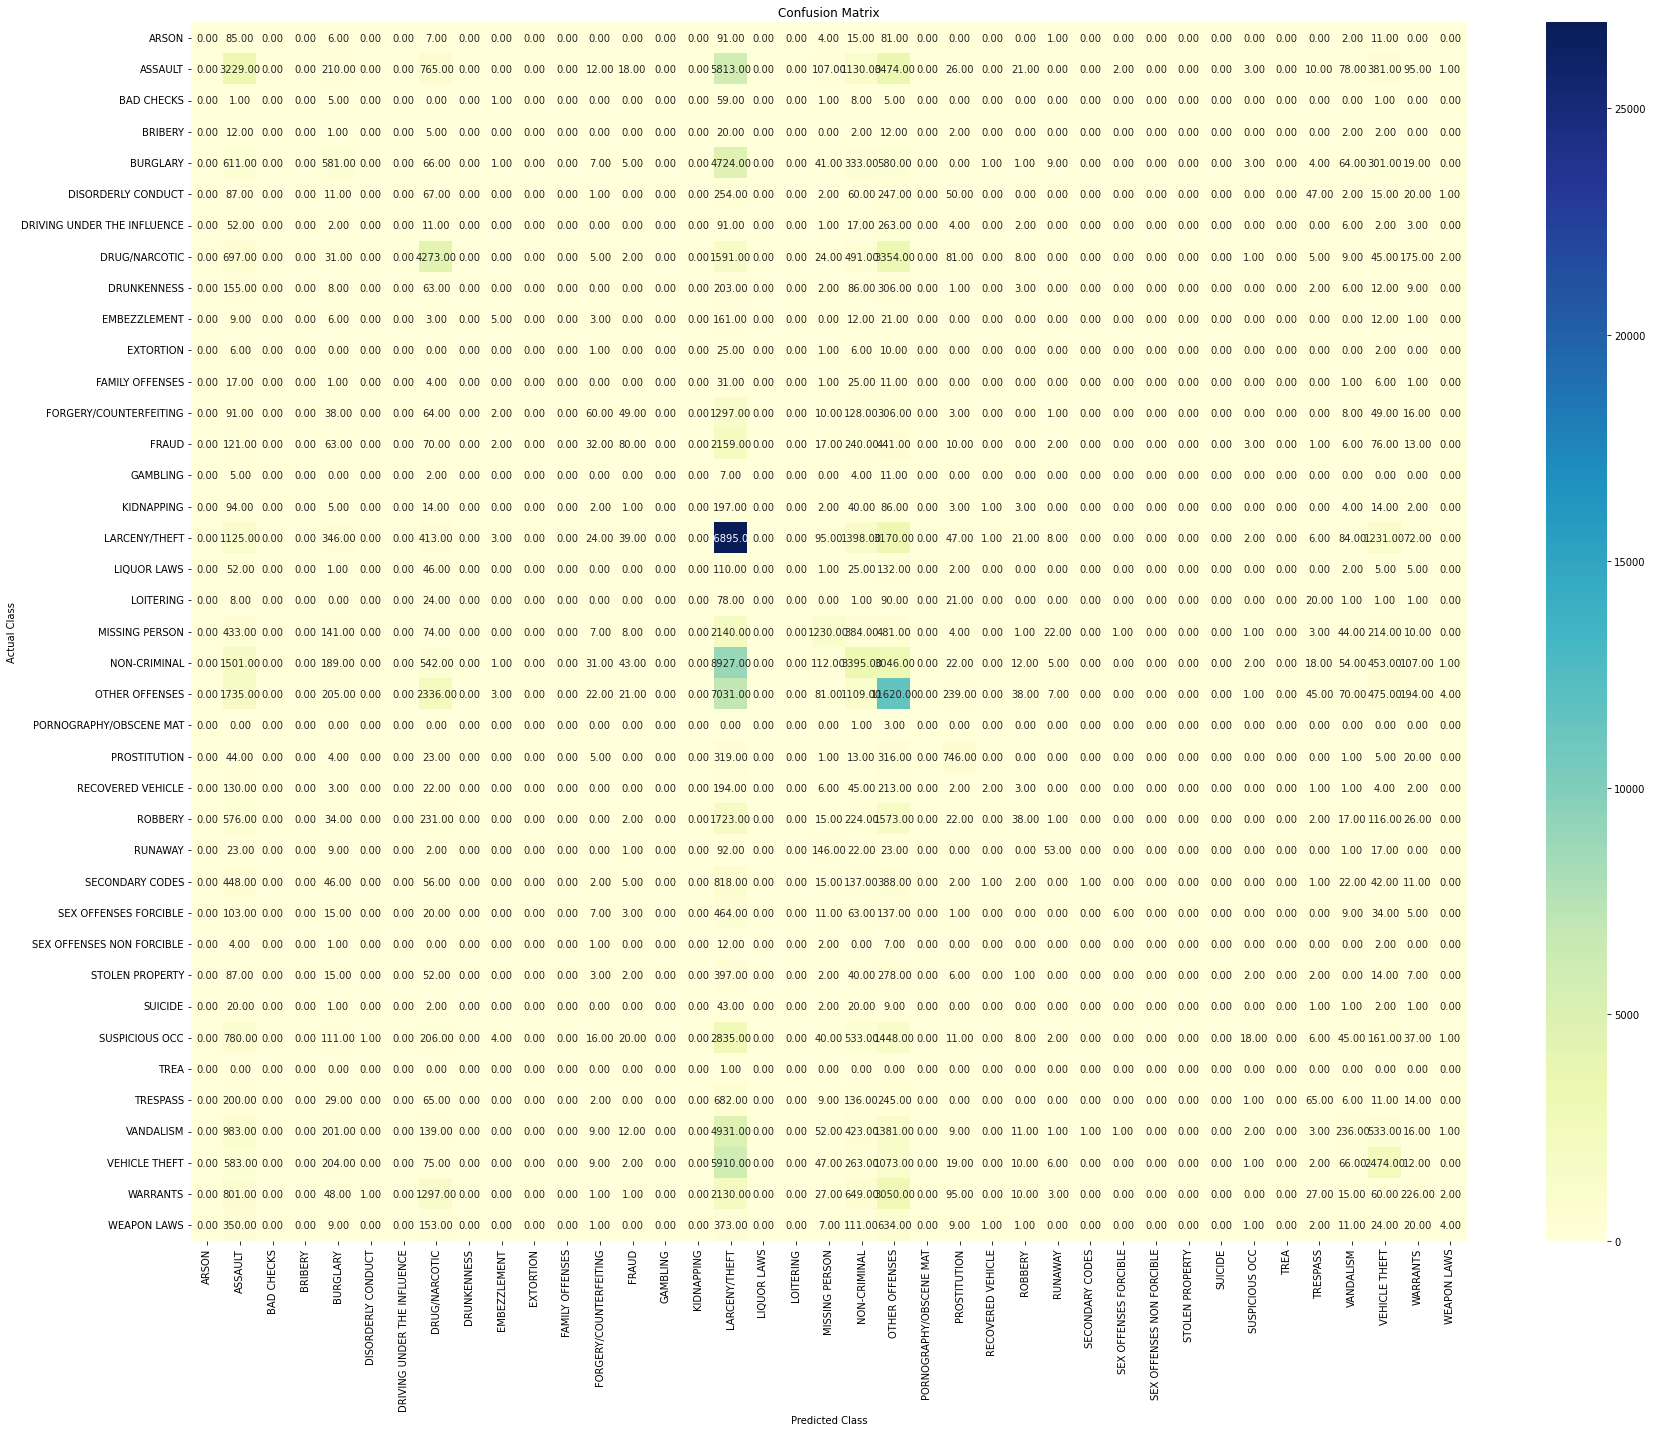

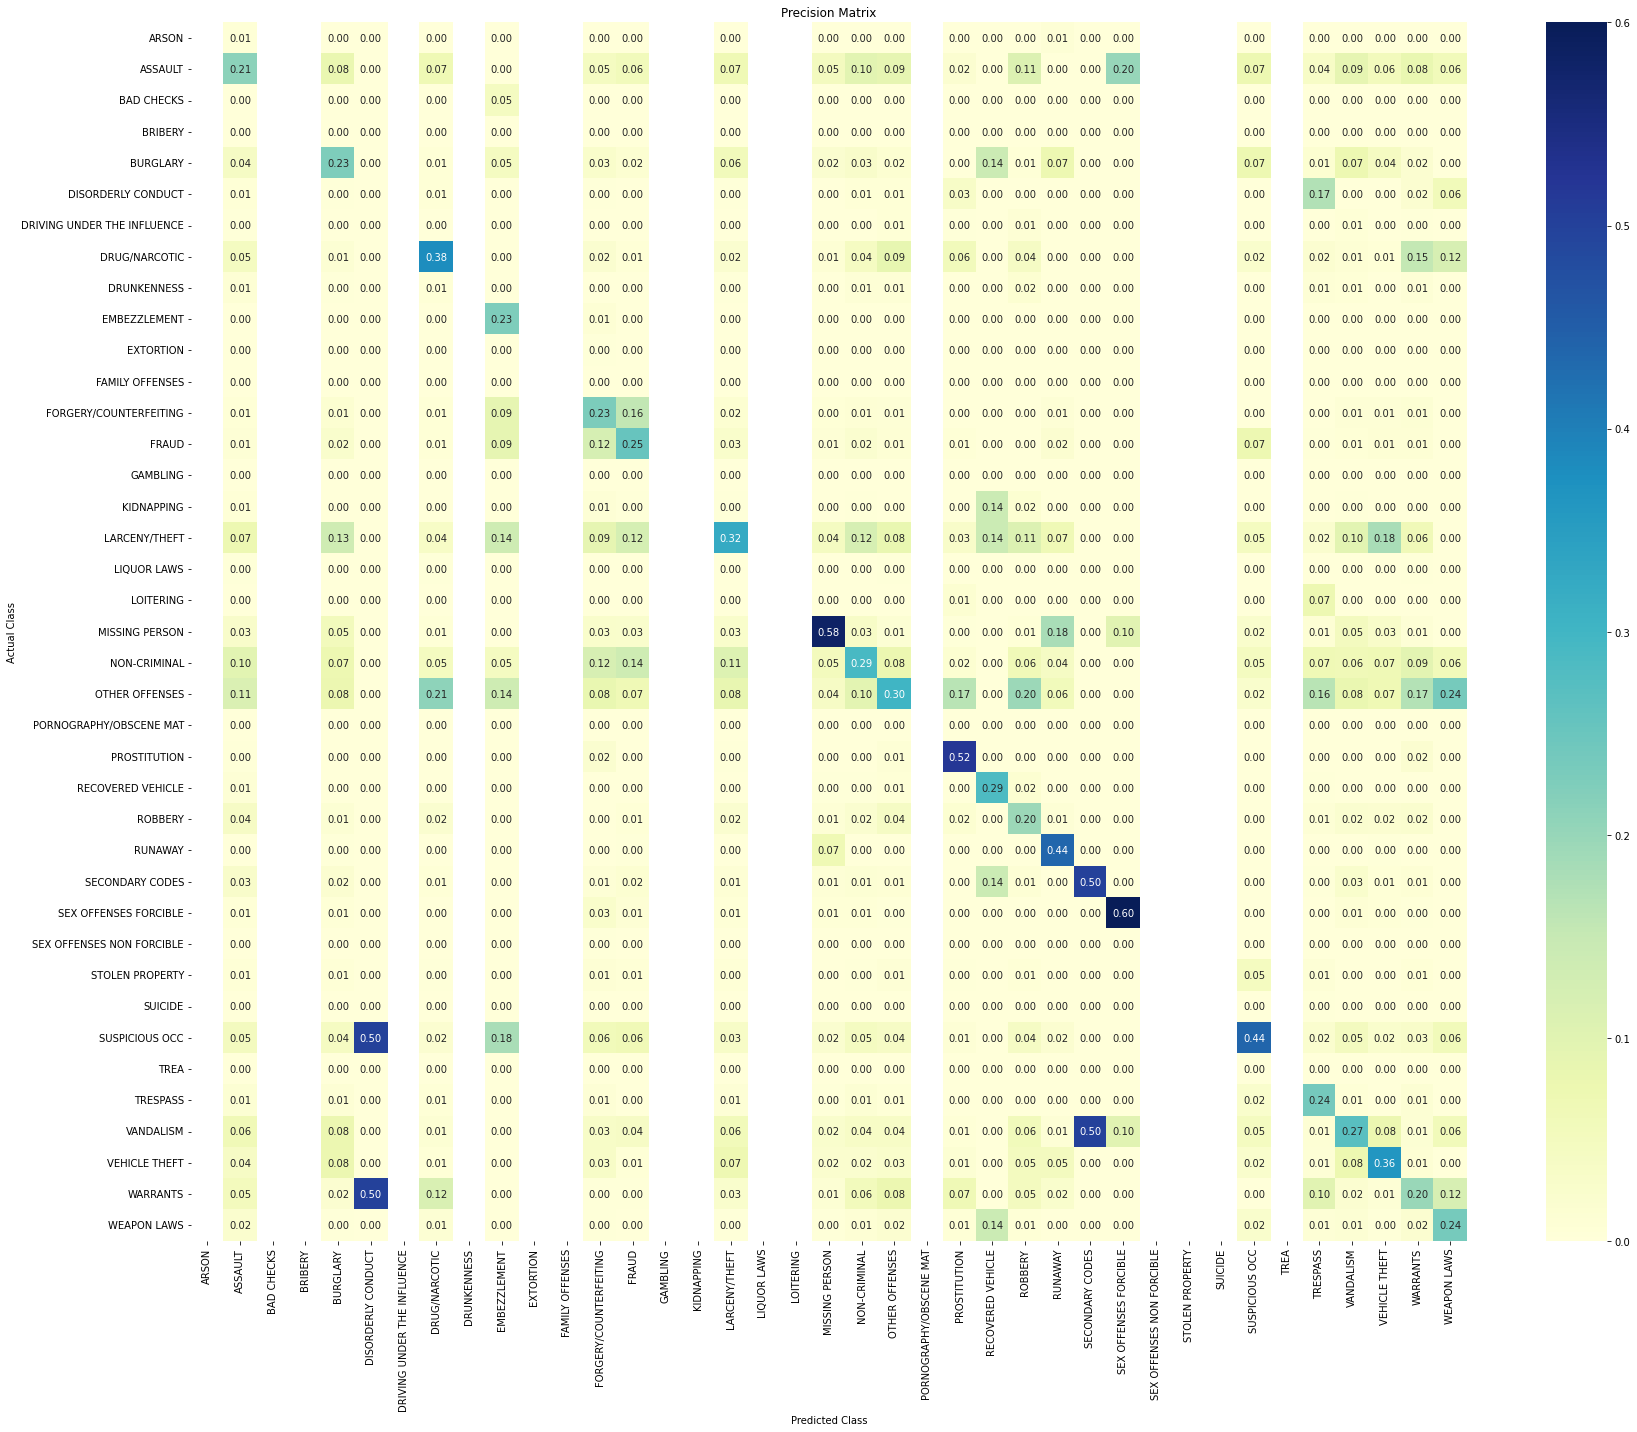

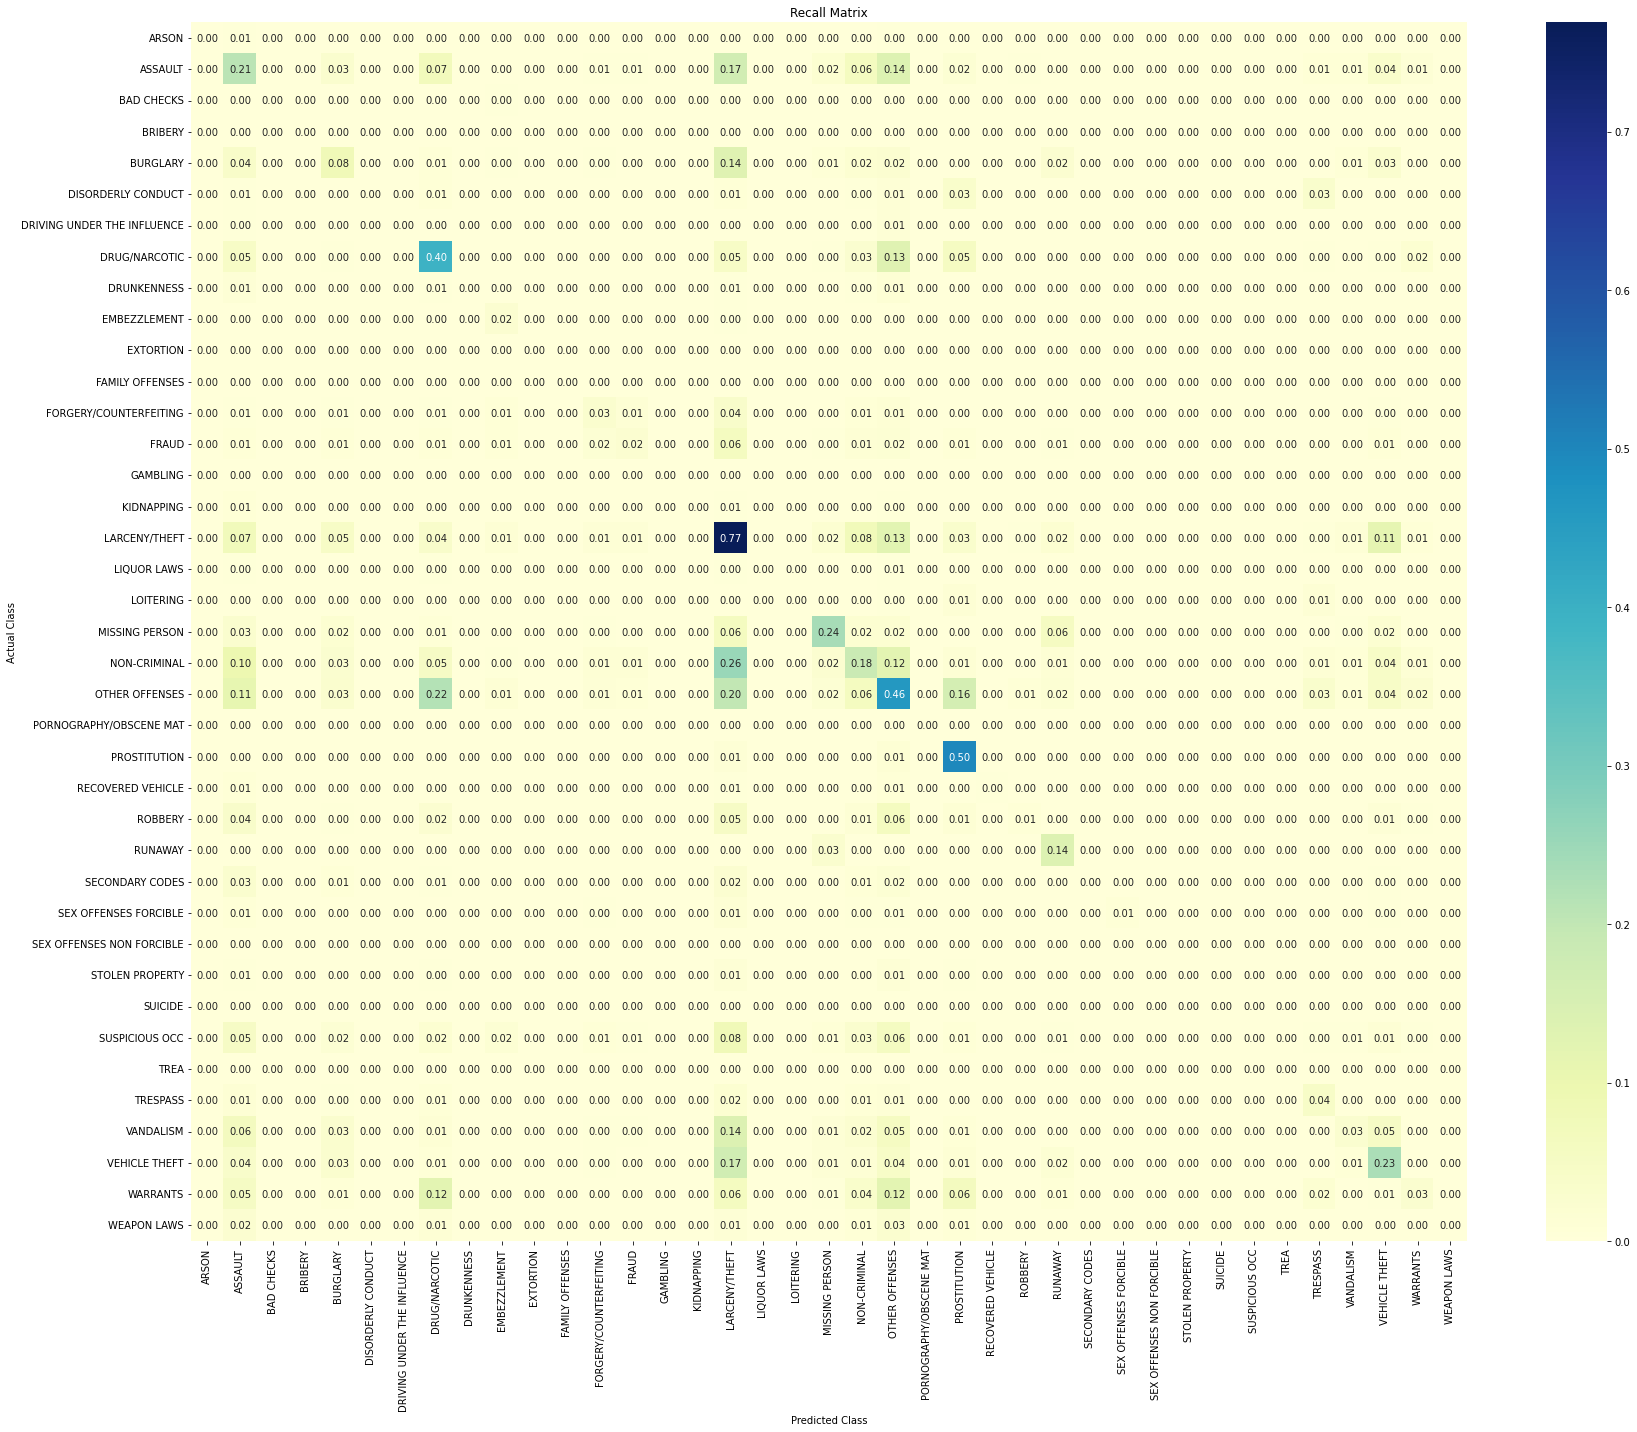

                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       303
                    ASSAULT       0.21      0.21      0.21     15375
                 BAD CHECKS       0.00      0.00      0.00        81
                    BRIBERY       0.00      0.00      0.00        58
                   BURGLARY       0.23      0.08      0.12      7351
         DISORDERLY CONDUCT       0.00      0.00      0.00       864
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       454
              DRUG/NARCOTIC       0.38      0.40      0.39     10794
                DRUNKENNESS       0.00      0.00      0.00       856
               EMBEZZLEMENT       0.23      0.02      0.04       233
                  EXTORTION       0.00      0.00      0.00        51
            FAMILY OFFENSES       0.00      0.00      0.00        98
     FORGERY/COUNTERFEITING       0.23      0.03      0.05      2122
                      FRAUD      

In [21]:
dt_train_loss, dt_valid_loss, dt_test_loss = decision_tree_classifier(X_train, y_train, X_valid, y_valid, X_test, y_test)

### 4. RandomForest Classifier

In [22]:
def random_forest_classifier(X_train, y_train, X_valid, y_valid, X_test, y_test, show_plot=True):
    model_path = project_path + 'models/'
    model_name = 'random_forest_classifier.pkl'

    if not os.path.isfile(path=model_path + model_name):
        clf = RandomForestClassifier(max_depth=8, n_estimators=100)
        clf.fit(X_train, y_train)

        sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
        sig_clf.fit(X_train, y_train)
    
        pickle.dump(sig_clf, open(model_path + model_name, 'wb'))
    else:
        print('Model already exists.')
        sig_clf = pickle.load(open(model_path + model_name, 'rb'))

    y_train_preds = sig_clf.predict_proba(X_train)
    train_log_loss = log_loss(y_train, y_train_preds)
    print("Training Log Loss:", train_log_loss)

    y_valid_preds = sig_clf.predict_proba(X_valid)
    valid_log_loss = log_loss(y_valid, y_valid_preds)
    print("Validation Log Loss:", valid_log_loss)

    y_test_preds = sig_clf.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_test_preds)
    print("Testing Log Loss:", test_log_loss)

    if show_plot:
        predict_y = sig_clf.predict(X_test)
        plot_confusion_matrix(y_actuals=y_test, y_preds=predict_y)
    
    classification_report = metrics.classification_report(y_test, predict_y)
    print(classification_report)

    return train_log_loss, valid_log_loss, test_log_loss

Model already exists.
Training Log Loss: 2.40207622084408
Validation Log Loss: 2.397730262848481
Testing Log Loss: 2.399864731597032


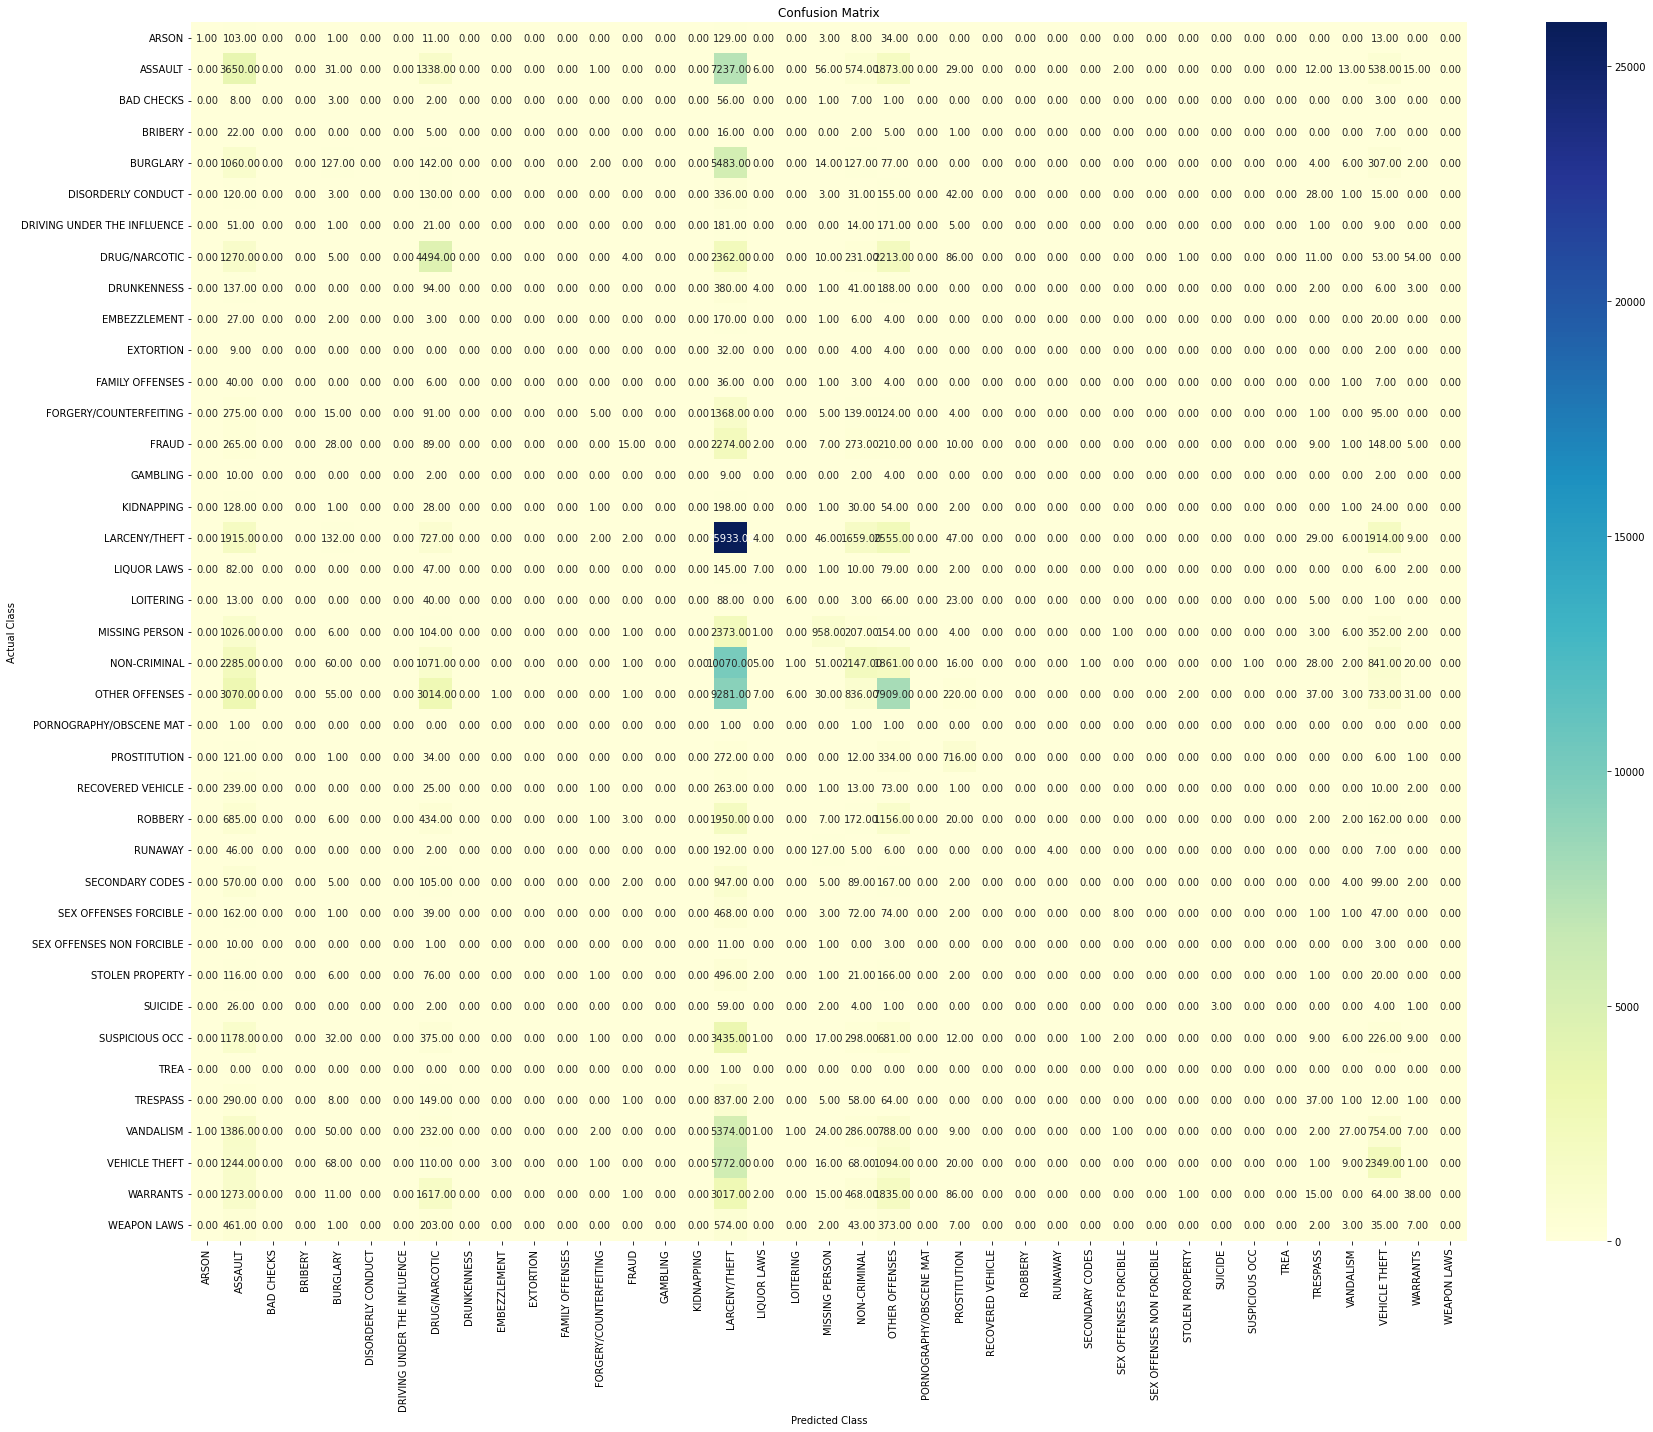

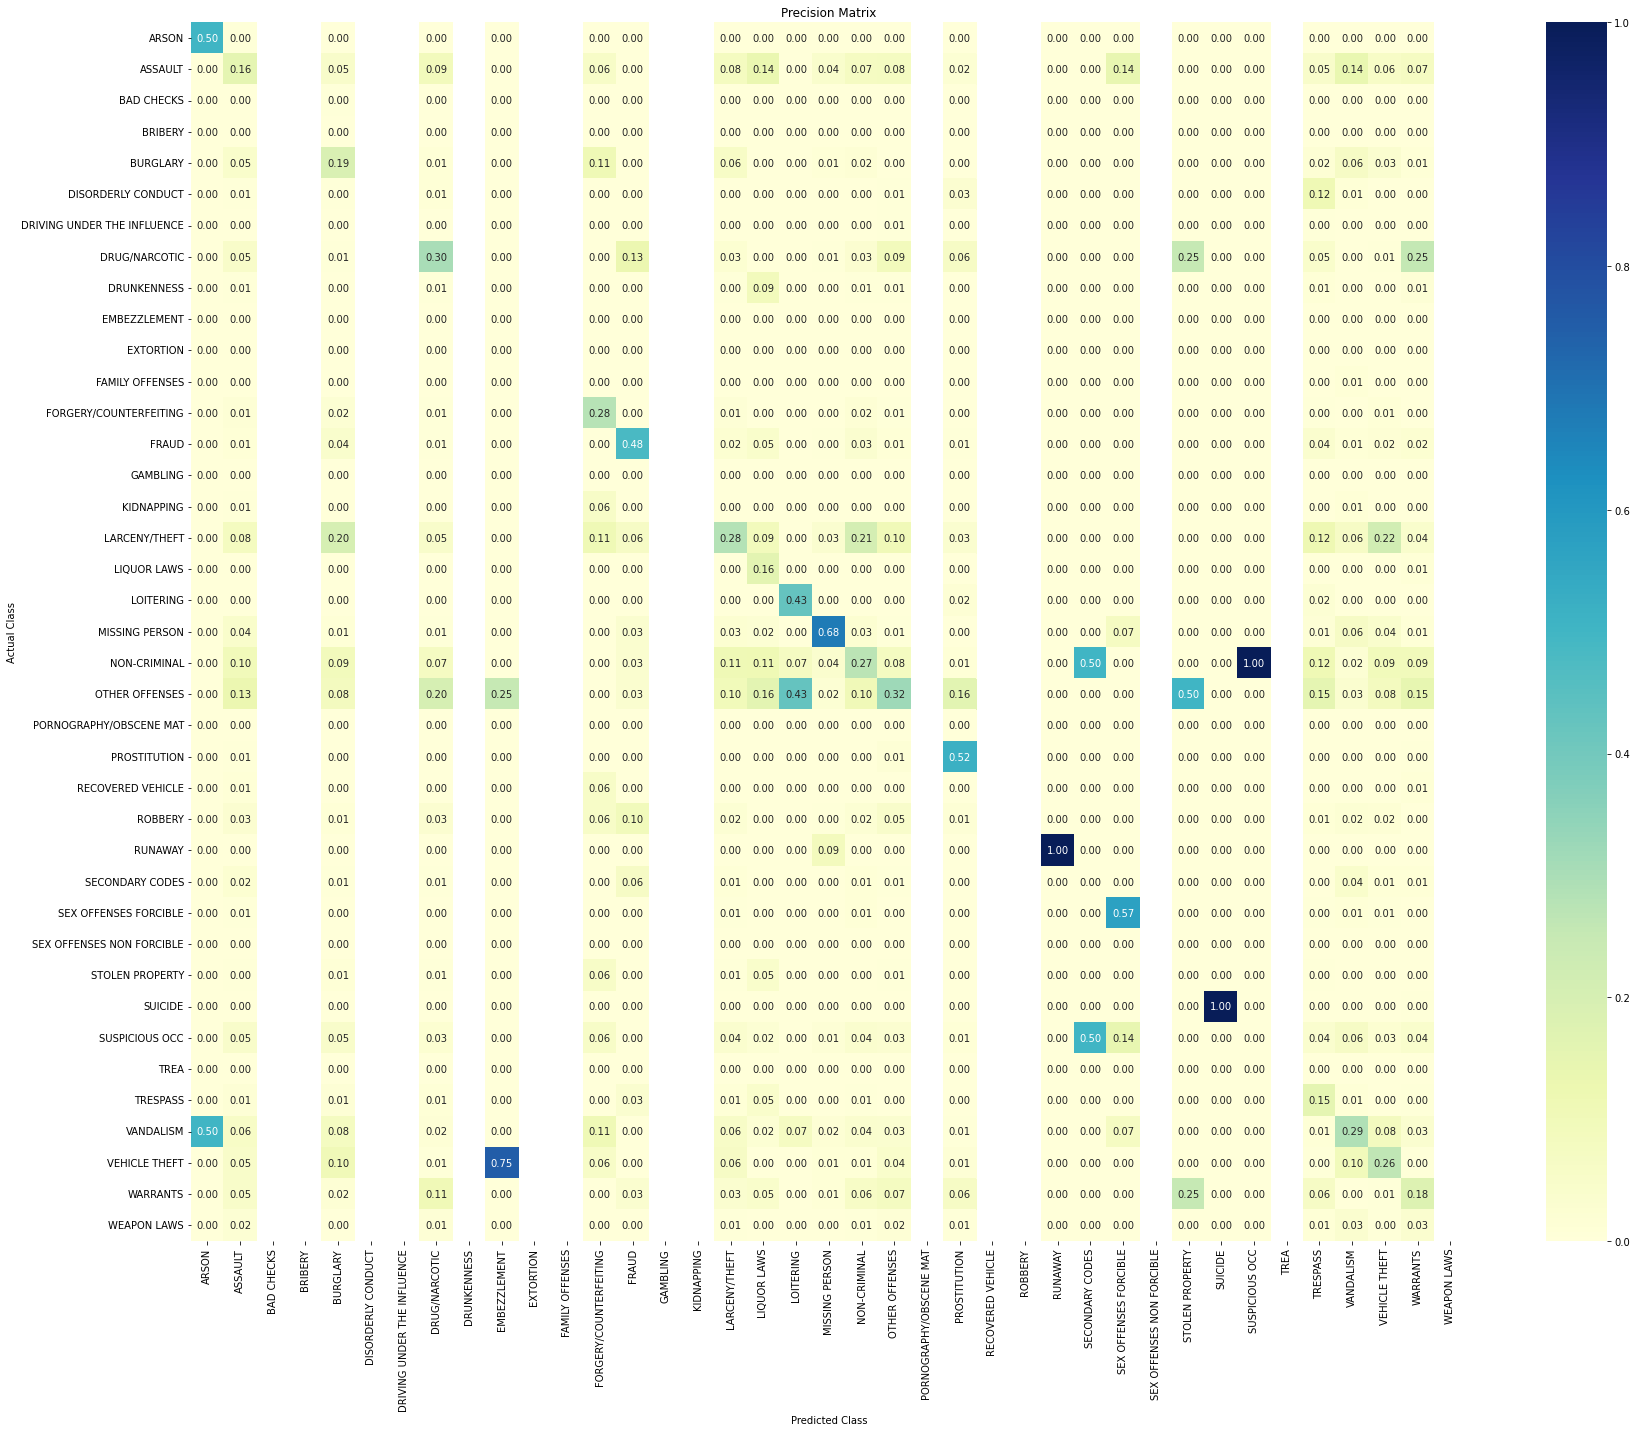

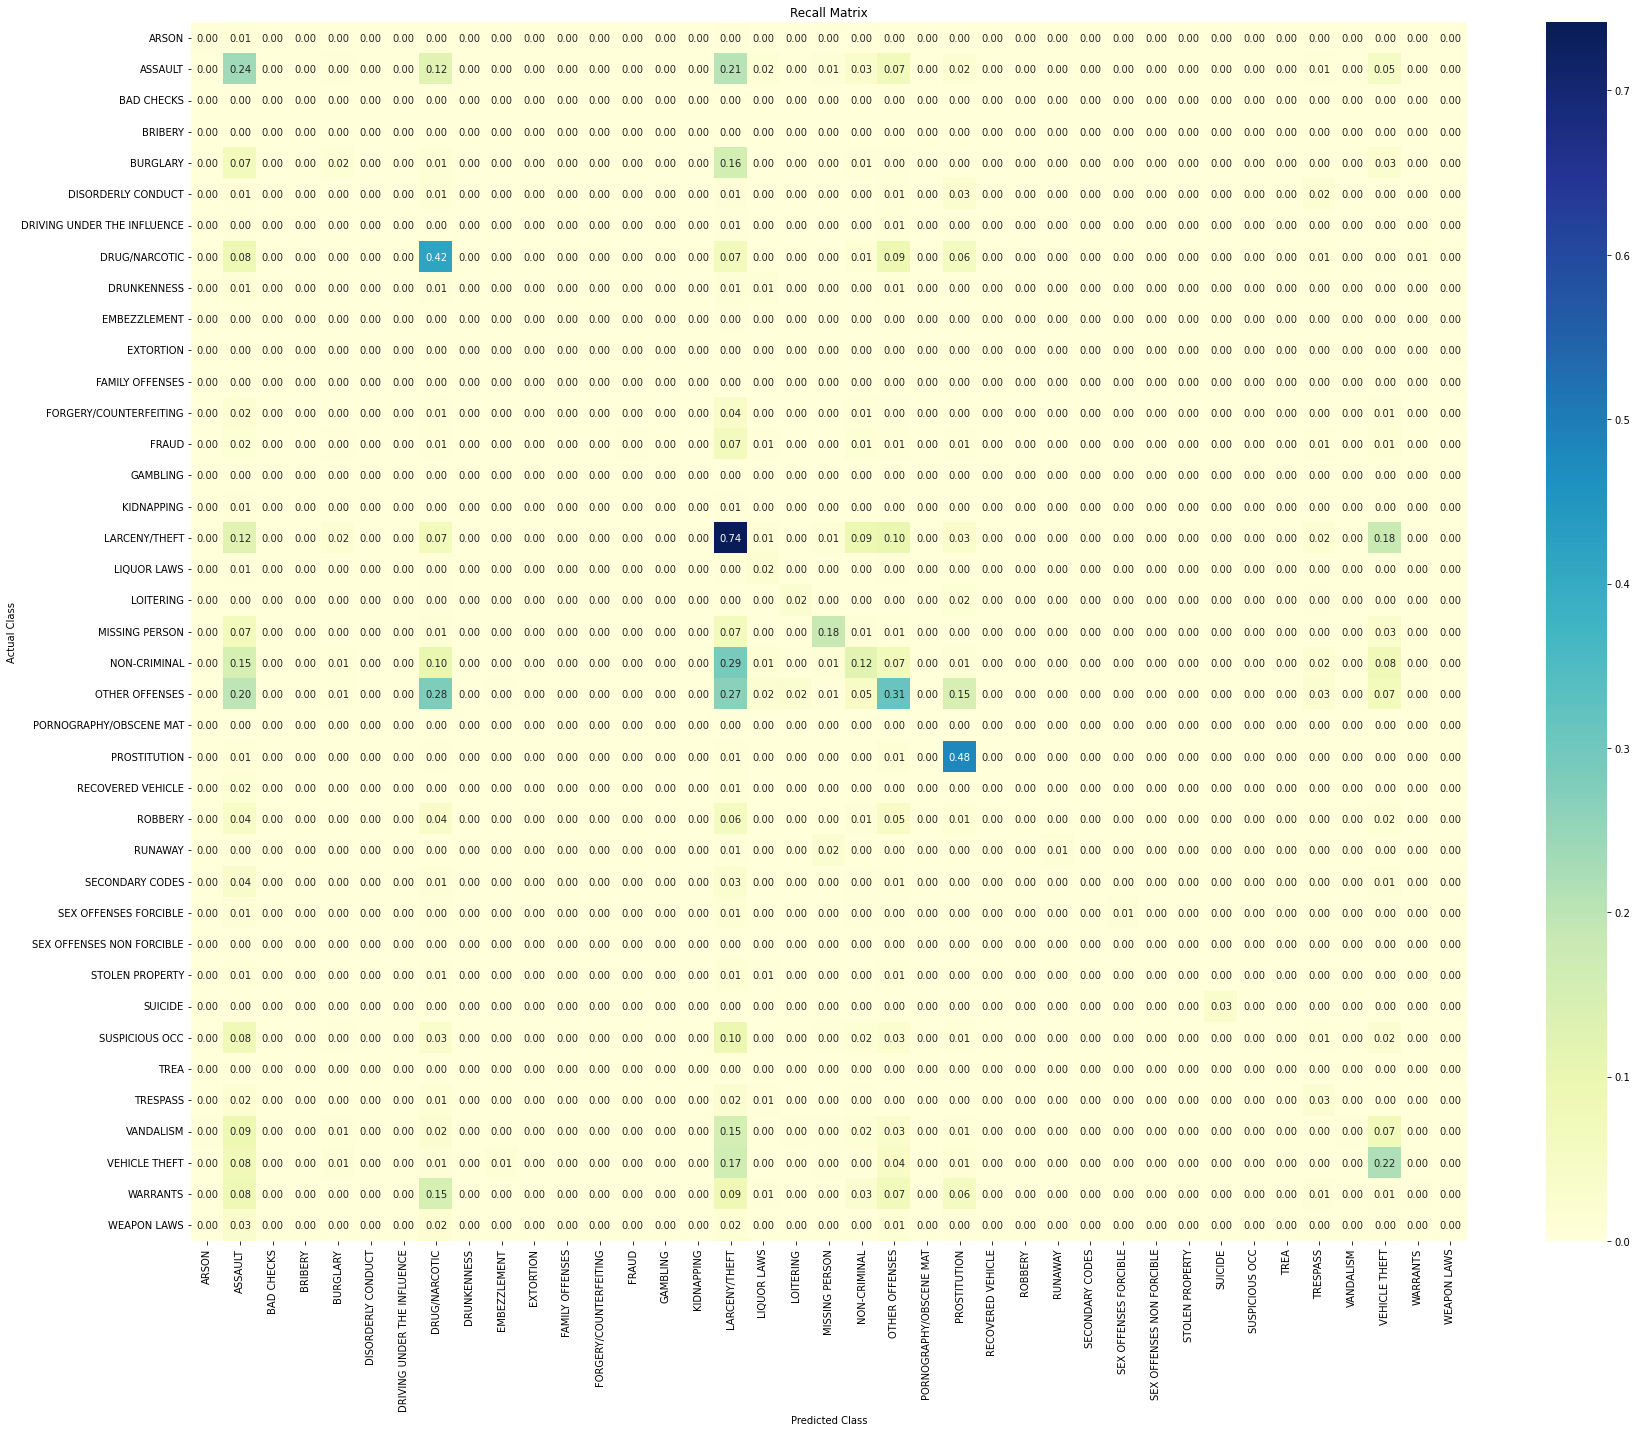

                             precision    recall  f1-score   support

                      ARSON       0.50      0.00      0.01       303
                    ASSAULT       0.16      0.24      0.19     15375
                 BAD CHECKS       0.00      0.00      0.00        81
                    BRIBERY       0.00      0.00      0.00        58
                   BURGLARY       0.19      0.02      0.03      7351
         DISORDERLY CONDUCT       0.00      0.00      0.00       864
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       454
              DRUG/NARCOTIC       0.30      0.42      0.35     10794
                DRUNKENNESS       0.00      0.00      0.00       856
               EMBEZZLEMENT       0.00      0.00      0.00       233
                  EXTORTION       0.00      0.00      0.00        51
            FAMILY OFFENSES       0.00      0.00      0.00        98
     FORGERY/COUNTERFEITING       0.28      0.00      0.00      2122
                      FRAUD      

In [23]:
rf_train_loss, rf_valid_loss, rf_test_loss = random_forest_classifier(X_train, y_train, X_valid, y_valid, X_test, y_test)

### 5. XGBoost Classifier

In [24]:
def xgboost_classifier(X_train, y_train, X_valid, y_valid, X_test, y_test, show_plot=True):
    model_path = project_path + 'models/'
    model_name = 'xgboost_multi_classifier.pkl'

    if not os.path.isfile(path=model_path + model_name):
        clf = XGBClassifier(max_depth=8, n_estimators=150, objective='multi:softmax', tree_method='gpu_hist')
        clf.fit(X_train, y_train)

        # clf = CalibratedClassifierCV(clf, method='sigmoid')
        # clf.fit(X_train, y_train)
    
        pickle.dump(clf, open(model_path + model_name, 'wb'))
    else:
        print('Model already exists.')
        clf = pickle.load(open(model_path + model_name, 'rb'))

    y_train_preds = clf.predict_proba(X_train)
    train_log_loss = log_loss(y_train, y_train_preds)
    print("Training Log Loss:", train_log_loss)

    y_valid_preds = clf.predict_proba(X_valid)
    valid_log_loss = log_loss(y_valid, y_valid_preds)
    print("Validation Log Loss:", valid_log_loss)

    y_test_preds = clf.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_test_preds)
    print("Testing Log Loss:", test_log_loss)

    if show_plot:
        predict_y = clf.predict(X_test)
        plot_confusion_matrix(y_actuals=y_test, y_preds=predict_y)
    
    classification_report = metrics.classification_report(y_test, predict_y)
    print(classification_report)

    return train_log_loss, valid_log_loss, test_log_loss

Model already exists.
Training Log Loss: 2.0676449576390876
Validation Log Loss: 2.0671005314196926
Testing Log Loss: 2.0648011478631125


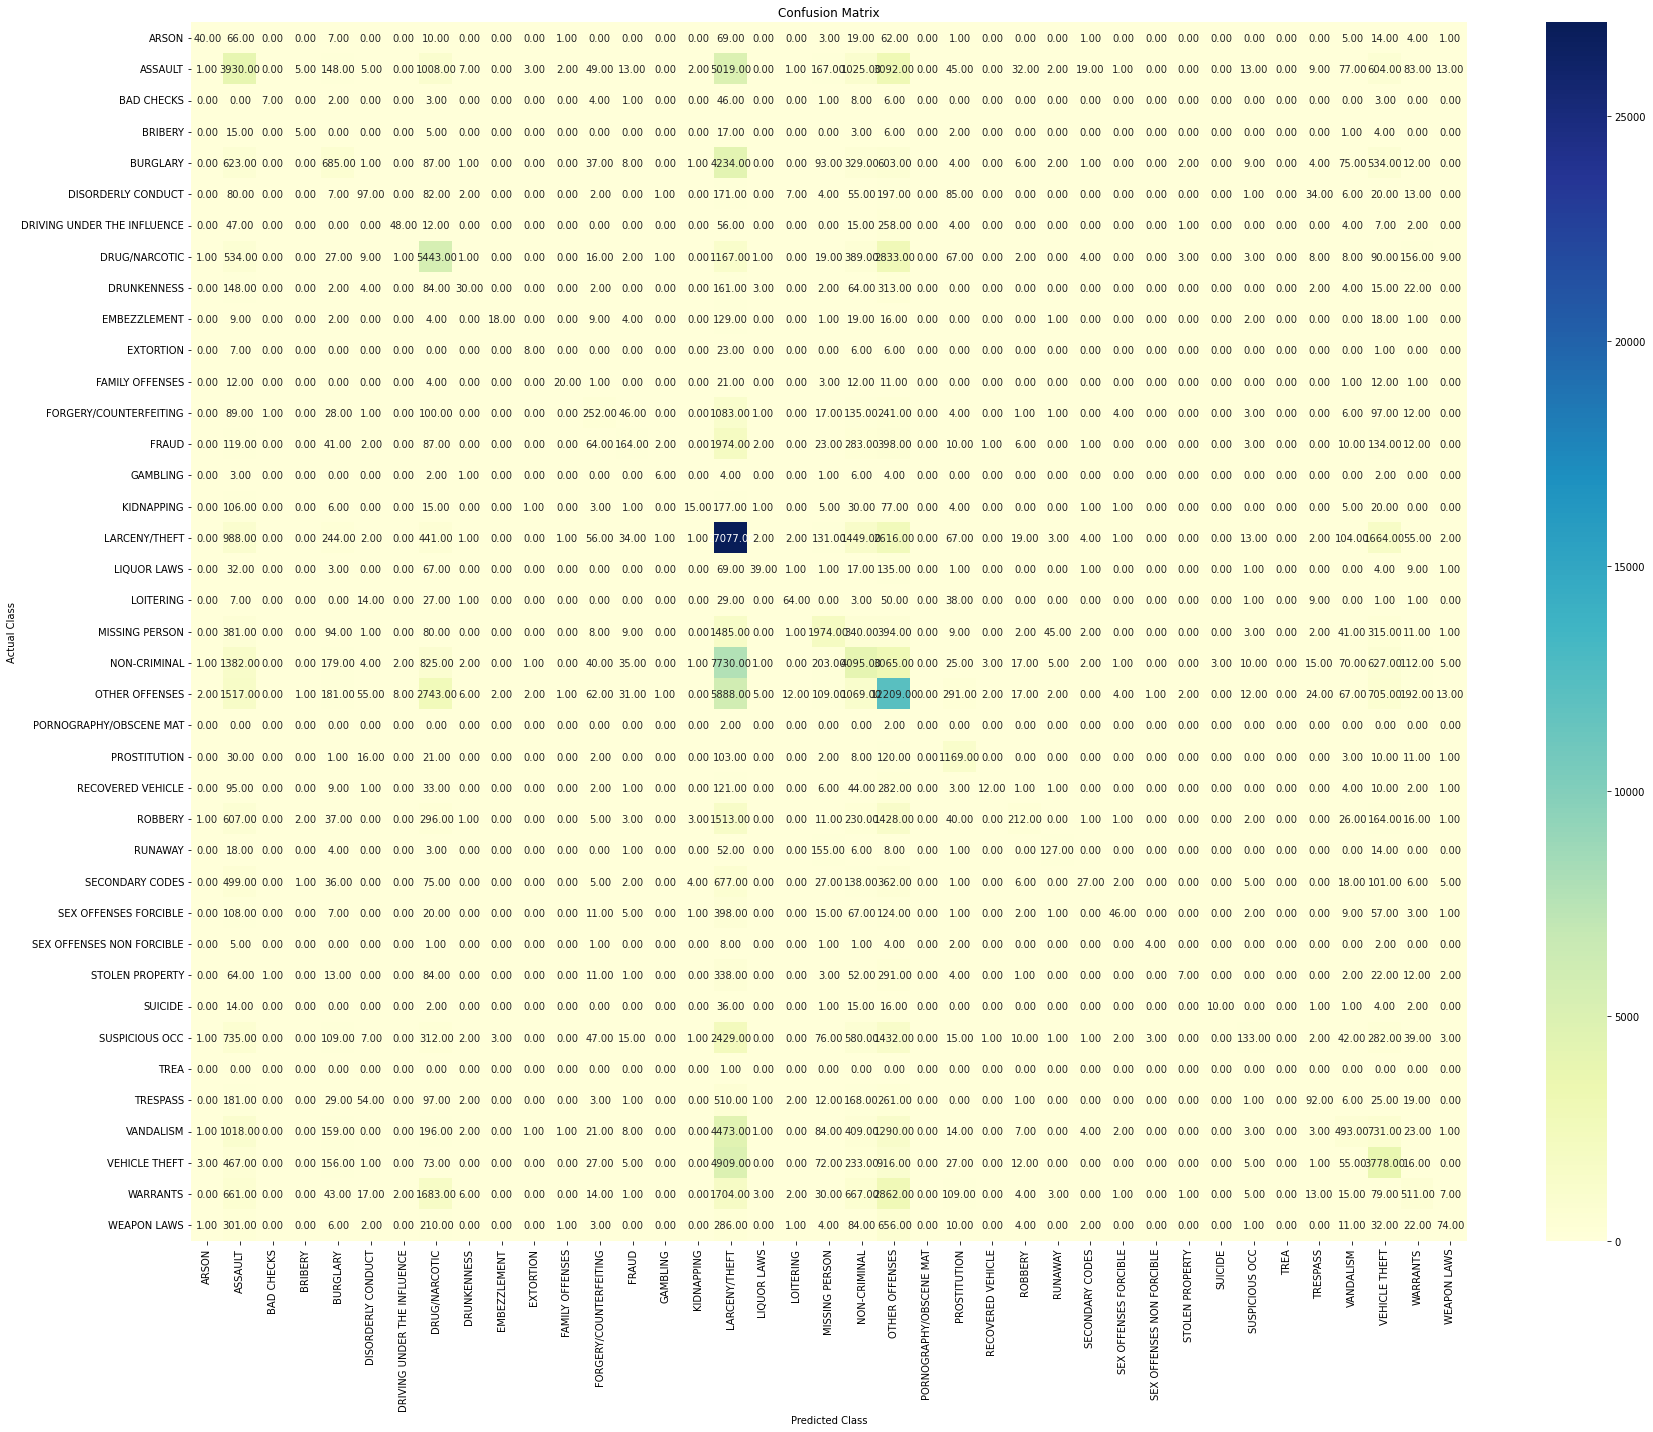

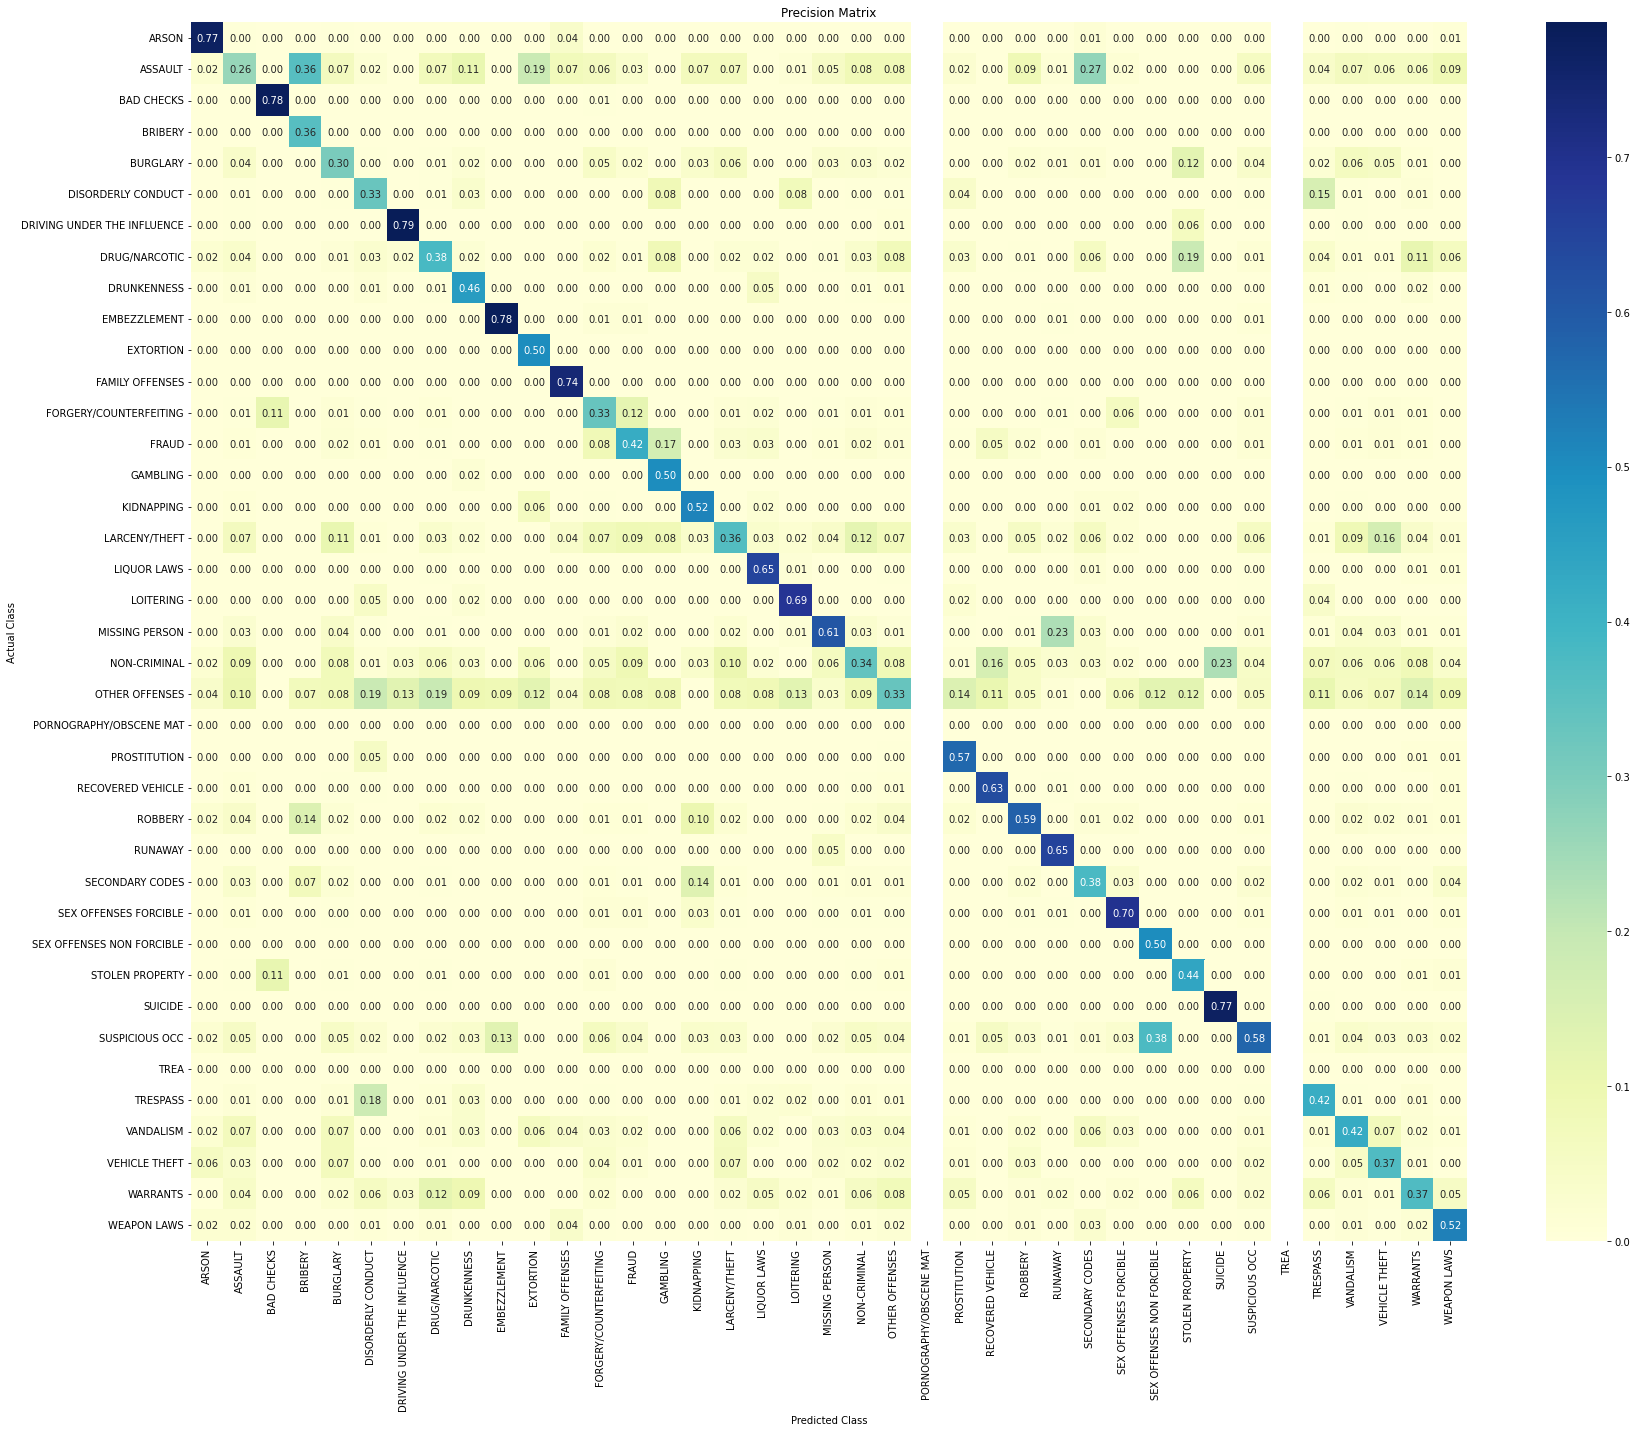

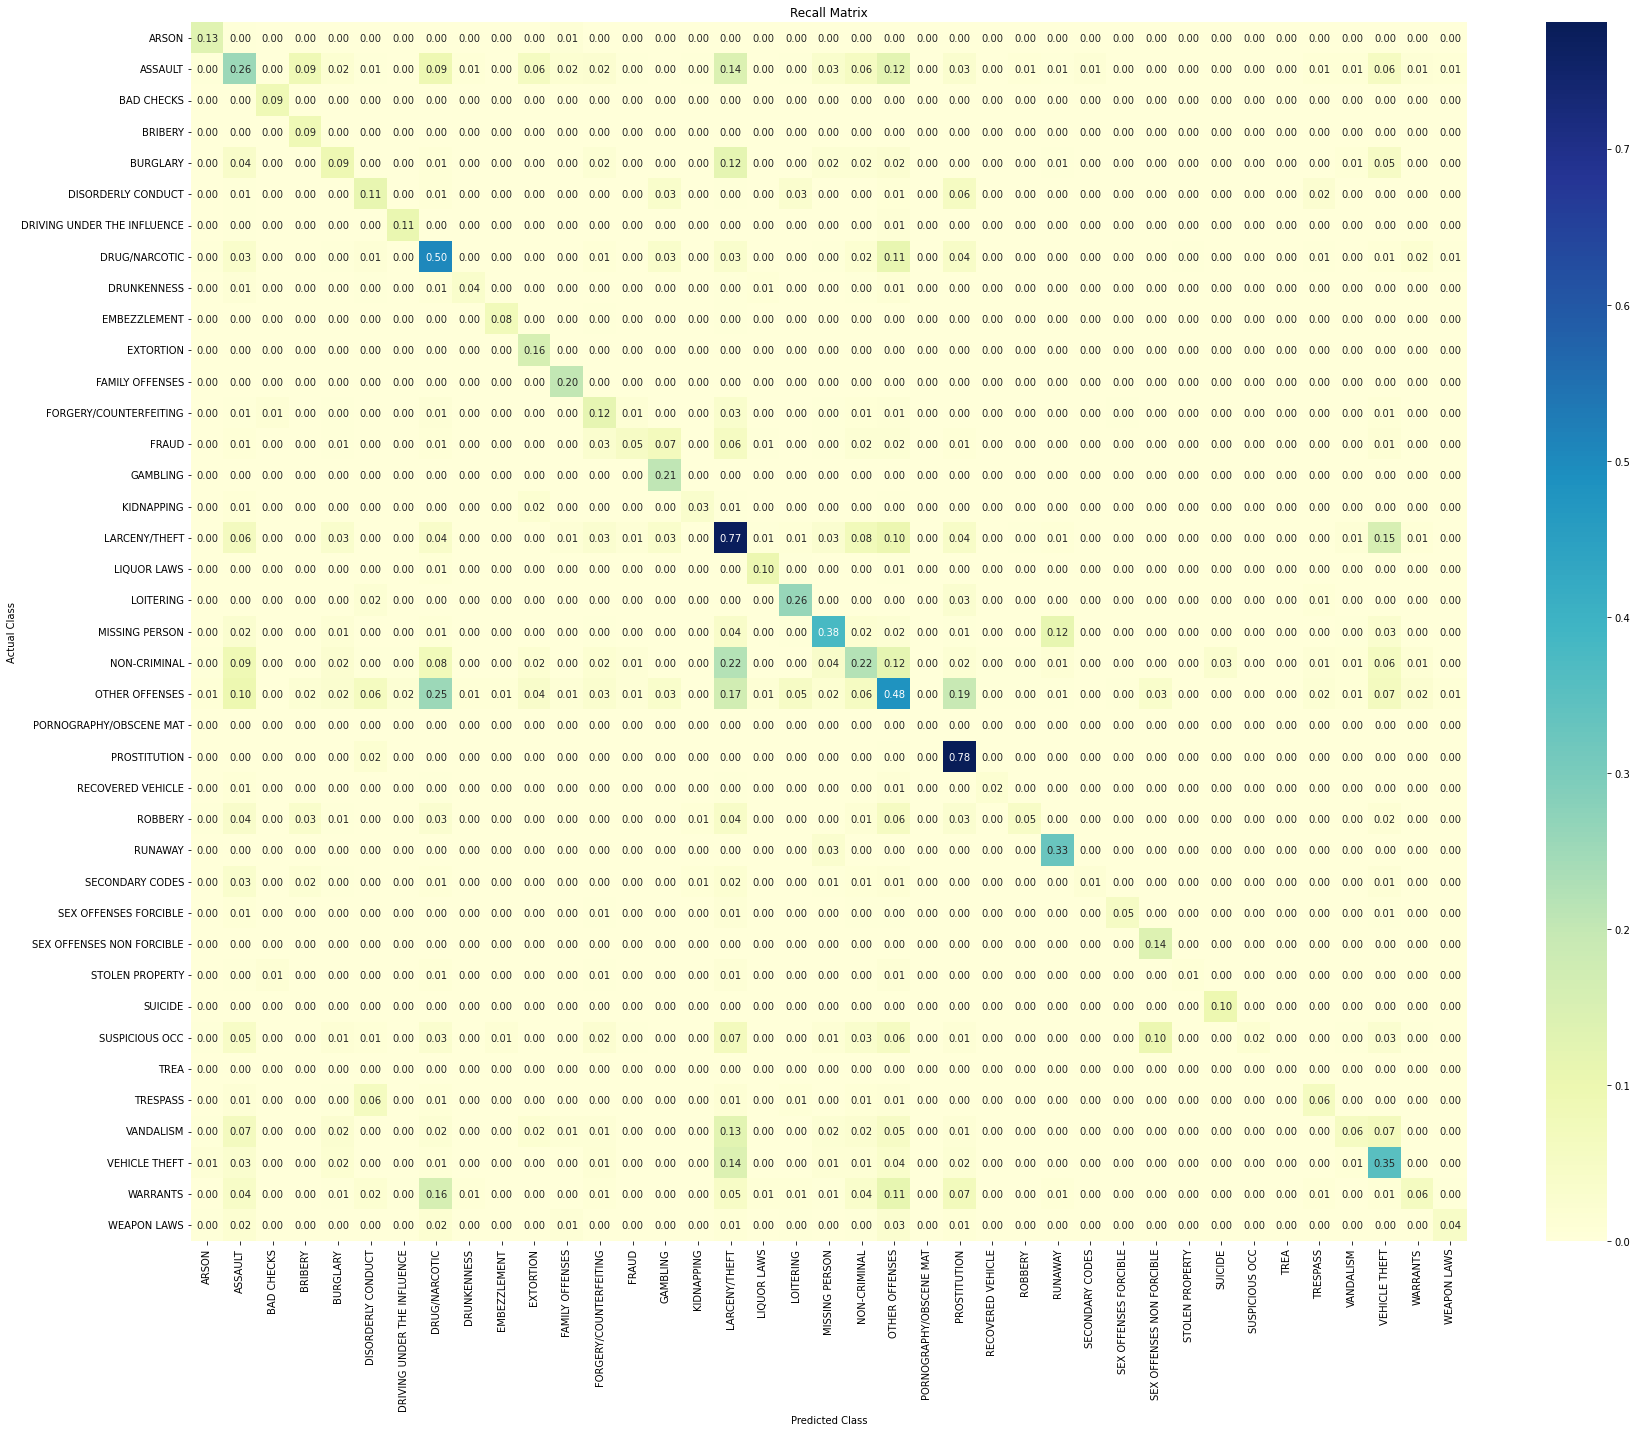

                             precision    recall  f1-score   support

                      ARSON       0.77      0.13      0.23       303
                    ASSAULT       0.26      0.26      0.26     15375
                 BAD CHECKS       0.78      0.09      0.16        81
                    BRIBERY       0.36      0.09      0.14        58
                   BURGLARY       0.30      0.09      0.14      7351
         DISORDERLY CONDUCT       0.33      0.11      0.17       864
DRIVING UNDER THE INFLUENCE       0.79      0.11      0.19       454
              DRUG/NARCOTIC       0.38      0.50      0.43     10794
                DRUNKENNESS       0.46      0.04      0.07       856
               EMBEZZLEMENT       0.78      0.08      0.14       233
                  EXTORTION       0.50      0.16      0.24        51
            FAMILY OFFENSES       0.74      0.20      0.32        98
     FORGERY/COUNTERFEITING       0.33      0.12      0.18      2122
                      FRAUD      

In [25]:
xgb_train_loss, xgb_valid_loss, xgb_test_loss = xgboost_classifier(X_train, y_train, X_valid, y_valid, X_test, y_test)

### Summary

In [26]:
model_names = ['Dummy Classifier', 'Logistic Regression', 'Decision Tree', 'RandomForest', 'XGBoost Classifier']
train_losses = [dummy_train_loss, lr_train_loss, dt_train_loss, rf_train_loss, xgb_train_loss]
valid_losses = [dummy_valid_loss, lr_valid_loss, dt_valid_loss, rf_valid_loss, xgb_valid_loss]
test_losses = [dummy_test_loss, lr_test_loss, dt_test_loss, rf_test_loss, xgb_test_loss]

summary_df = pd.DataFrame()
summary_df['Models'] = model_names
summary_df['Train Loss'] = train_losses
summary_df['Valid Loss'] = valid_losses
summary_df['Test Loss'] = test_losses

summary = tabulate(tabular_data=summary_df, headers='keys', tablefmt='psql')
print(summary)

+----+---------------------+--------------+--------------+-------------+
|    | Models              |   Train Loss |   Valid Loss |   Test Loss |
|----+---------------------+--------------+--------------+-------------|
|  0 | Dummy Classifier    |      2.68033 |      2.68034 |     2.6803  |
|  1 | Logistic Regression |      2.50036 |      2.49685 |     2.49812 |
|  2 | Decision Tree       |      2.34158 |      2.34025 |     2.33833 |
|  3 | RandomForest        |      2.40208 |      2.39773 |     2.39986 |
|  4 | XGBoost Classifier  |      2.06764 |      2.0671  |     2.0648  |
+----+---------------------+--------------+--------------+-------------+


* From the above, we can observe that the all models (except DummyClassifier) performed well.
    - The loss of each model is less than the `DummyClassifier`.
    - The best model compared to all other models is `XGBoost`. The loss of this very less.